In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy import stats
from datetime import datetime

# Seaborn style settings
sns.set_theme(style="ticks", palette="mako")

## Load and Prepare Data

In [2]:
master_df = pd.read_csv("data/2016_2021_master_df.csv")
master_df["DATE_PST"] = pd.to_datetime(master_df["DATE_PST"])
master_df.set_index("DATE_PST", inplace=True)
display(master_df.head())
print(master_df.shape)

Vancouver_Clark_Drive_PM25  \
DATE_PST                                          
2016-01-01 01:00:00                      30.557   
2016-01-01 02:00:00                      34.661   
2016-01-01 03:00:00                      35.419   
2016-01-01 04:00:00                      24.335   
2016-01-01 05:00:00                      29.336   

                     Vancouver_International_Airport_#2_PM25  \
DATE_PST                                                       
2016-01-01 01:00:00                                 22.71692   
2016-01-01 02:00:00                                 21.95020   
2016-01-01 03:00:00                                 21.25953   
2016-01-01 04:00:00                                 19.93333   
2016-01-01 05:00:00                                 19.07922   

                     North_Vancouver_Mahon_Park_PM25  \
DATE_PST                                               
2016-01-01 01:00:00                        22.798870   
2016-01-01 02:00:00                        22.909090   
2016-01-01 03:00:00                        19.857730   
2016-01-01 04:00:00                        13.575990   
2016-01-01 05:00:00                         7.079589   

                     North_Vancouver_Second_Narrows_PM25  
DATE_PST                                                  
2016-01-01 01:00:00                                  NaN  
2016-01-01 02:00:00                             6.341111  
2016-01-01 03:00:00                             5.340278  
2016-01-01 04:00:00                             3.907917  
2016-01-01 05:00:00                             7.235889

(57014, 4)


### Preprocessing
- Subset stations
- Missingness metadata

In [3]:
# Melting
master_df = pd.melt(master_df,
                    value_vars=[
                    "Vancouver_Clark_Drive_PM25",\
                    "Vancouver_International_Airport_#2_PM25",\
                    "North_Vancouver_Mahon_Park_PM25",\
                    "North_Vancouver_Second_Narrows_PM25"
                    ],
                    ignore_index=False).rename(columns={
                    "variable": "Station",
                    "value": "PM 2.5"})
display(master_df.head())
print(master_df.shape)

Station  PM 2.5
DATE_PST                                               
2016-01-01 01:00:00  Vancouver_Clark_Drive_PM25  30.557
2016-01-01 02:00:00  Vancouver_Clark_Drive_PM25  34.661
2016-01-01 03:00:00  Vancouver_Clark_Drive_PM25  35.419
2016-01-01 04:00:00  Vancouver_Clark_Drive_PM25  24.335
2016-01-01 05:00:00  Vancouver_Clark_Drive_PM25  29.336

(228056, 2)


In [4]:
# Dummy variable to keep track of missing samples and missing sample length
master_df["isMissing"] = np.where(master_df["PM 2.5"].isnull(), 1, 0)
master_df.head()

Station  PM 2.5  isMissing
DATE_PST                                                          
2016-01-01 01:00:00  Vancouver_Clark_Drive_PM25  30.557          0
2016-01-01 02:00:00  Vancouver_Clark_Drive_PM25  34.661          0
2016-01-01 03:00:00  Vancouver_Clark_Drive_PM25  35.419          0
2016-01-01 04:00:00  Vancouver_Clark_Drive_PM25  24.335          0
2016-01-01 05:00:00  Vancouver_Clark_Drive_PM25  29.336          0

In [5]:
master_df['isMissing'].sum()

4958

In [6]:
# List of stations
stations = master_df["Station"].unique().tolist()
stations

['Vancouver_Clark_Drive_PM25',
 'Vancouver_International_Airport_#2_PM25',
 'North_Vancouver_Mahon_Park_PM25',
 'North_Vancouver_Second_Narrows_PM25']

In [7]:
# Isolating stations on independent dataframes
datasets = {}
for station in stations:
    datasets[station] = master_df[master_df["Station"] == station]
    datasets[station] = datasets[station][["PM 2.5", "isMissing"]]
    datasets[station].reset_index(inplace=True)

datasets.keys()

dict_keys(['Vancouver_Clark_Drive_PM25', 'Vancouver_International_Airport_#2_PM25', 'North_Vancouver_Mahon_Park_PM25', 'North_Vancouver_Second_Narrows_PM25'])

In [8]:
# Reference darts.utils.missing_values.extract_subseries as an alternative method!

def count_sequences(data, time, value):
    '''
    Count sequences lengths of missing and non-missing intervals in a time series DataFrame.
    Parameters:
        data: Pandas DataFrame with a time series and a value column.
        time: DateTime variable in the dataset.
        value: Value variable to subset with date column.
    Returns:
        Pandas DataFrame with sequences lengths, indicating sequences start and end IDs and time stamps.
    '''
    # Indexer for not-missing value on data
    is_not_nan = ~data[value].isna()

    # Auxiliary indexer to group sequences
    # diff and cumsum aggregate non-missing sequences
    group_idx = is_not_nan.diff().cumsum().fillna(0) # fillna(0) resolves cumsum's 'NaN' on idx = 0

    # Not-missing counter
    not_nan_counts = is_not_nan.groupby(group_idx).sum()

    # Instantiate sequence lengths DataFrame and retrieve position indices and time
    sequences_df = pd.Series(np.arange(len(data))).groupby(group_idx).agg(['min', 'max'])
    sequences_df['seq_start_time'] = sequences_df['min'].map(data[time])
    sequences_df['seq_end_time'] = sequences_df['max'].map(data[time])
    sequences_df['not_nan_count'] = not_nan_counts
    sequences_df['nan_count'] = (sequences_df['max'] - sequences_df['min']) - (sequences_df['not_nan_count'] - 1)
    
    # Assert sum of sequence lengths == total series length
    assert sum(sequences_df[['not_nan_count', 'nan_count']].sum()) == data.shape[0]

    # Tidy up
    sequences_df.rename(columns={'min': 'seq_start_idx', 'max': 'seq_end_idx'}, inplace=True)
    sequences_df.sort_values('seq_start_idx', inplace=True)
    sequences_df.reset_index(drop=True, inplace=True)

    return sequences_df

### Thresholding missing sequence length
* Isolated Missing Value (IMV)
* Continuous Missing Value (CMV)

In [9]:
IMV_THRESHOLD = 2

metadata = {}
for station in stations:
    metadata[station] = count_sequences(datasets[station], time='DATE_PST', value='PM 2.5')
    # Continuous Missing Values (CMV) flag
    metadata[station]['isCMV'] = (metadata[station]['nan_count'] > IMV_THRESHOLD).astype(int)
    # Isolated Missing Values (IMV) flag
    metadata[station]['isIMV'] = (metadata[station]['nan_count'].isin([i for i in range(1, IMV_THRESHOLD+1)])).astype(int)

In [10]:
metadata['North_Vancouver_Second_Narrows_PM25'].head()

seq_start_idx  seq_end_idx      seq_start_time        seq_end_time  \
0              0            0 2016-01-01 01:00:00 2016-01-01 01:00:00   
1              1         1756 2016-01-01 02:00:00 2016-03-14 05:00:00   
2           1757         1759 2016-03-14 06:00:00 2016-03-14 08:00:00   
3           1760         1763 2016-03-14 09:00:00 2016-03-14 12:00:00   
4           1764         1764 2016-03-14 13:00:00 2016-03-14 13:00:00   

   not_nan_count  nan_count  isCMV  isIMV  
0              0          1      0      1  
1           1756          0      0      0  
2              0          3      1      0  
3              4          0      0      0  
4              0          1      0      1

In [11]:
for station in stations:
    for i, row in metadata[station].iterrows():
        seq_range = range(row['seq_start_idx'], row['seq_end_idx']+1)
        datasets[station].loc[seq_range, 'seqMissing'] = row['nan_count']
    datasets[station]['seqMissing'] = datasets[station]['seqMissing'].astype(int)

In [12]:
datasets['Vancouver_Clark_Drive_PM25'][datasets['Vancouver_Clark_Drive_PM25']['isMissing'] == 1]

DATE_PST  PM 2.5  isMissing  seqMissing
93    2016-01-04 22:00:00     NaN          1           9
94    2016-01-04 23:00:00     NaN          1           9
95    2016-01-05 00:00:00     NaN          1           9
96    2016-01-05 01:00:00     NaN          1           9
97    2016-01-05 02:00:00     NaN          1           9
...                   ...     ...        ...         ...
56096 2022-05-26 09:00:00     NaN          1           2
56700 2022-06-20 13:00:00     NaN          1           1
56792 2022-06-24 09:00:00     NaN          1           3
56793 2022-06-24 10:00:00     NaN          1           3
56794 2022-06-24 11:00:00     NaN          1           3

[1527 rows x 4 columns]

In [13]:
# Recomposing Master DataFrame
master_df = pd.concat(datasets).reset_index(level=0)

# Renaming station column
master_df["Station"] = master_df["level_0"]
master_df = master_df[["DATE_PST", "Station", "PM 2.5", "isMissing", "seqMissing"]]

# Redefining DATE_PST index
master_df.set_index("DATE_PST", inplace=True)
master_df.head()

Station  PM 2.5  isMissing  seqMissing
DATE_PST                                                                      
2016-01-01 01:00:00  Vancouver_Clark_Drive_PM25  30.557          0           0
2016-01-01 02:00:00  Vancouver_Clark_Drive_PM25  34.661          0           0
2016-01-01 03:00:00  Vancouver_Clark_Drive_PM25  35.419          0           0
2016-01-01 04:00:00  Vancouver_Clark_Drive_PM25  24.335          0           0
2016-01-01 05:00:00  Vancouver_Clark_Drive_PM25  29.336          0           0

## Visualizing Missingness

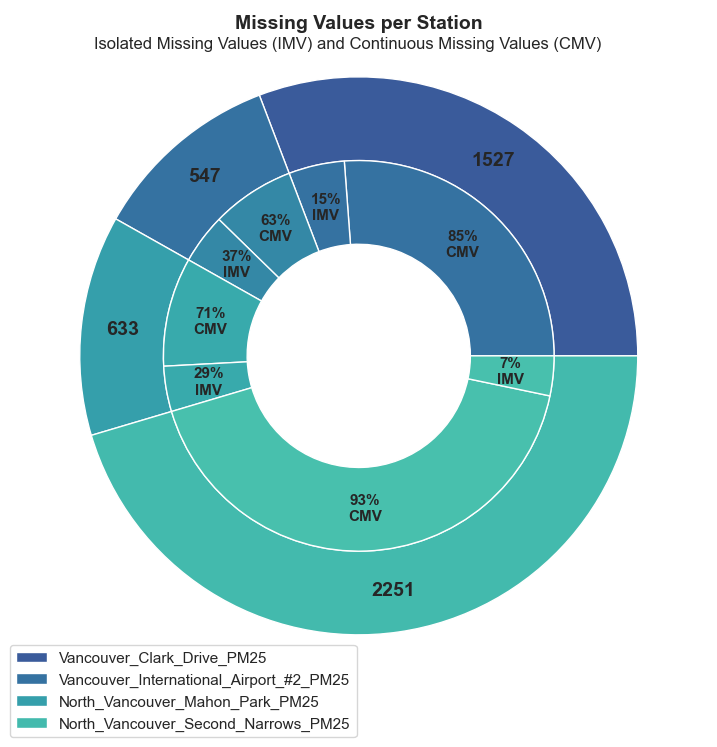

In [14]:
# Continuous Missing Values & Isolated Missing Values count
tot_missing = []
stations_cmv_imv = []
stations_cmv_imv_label = []

# Count of CMV and IMV intervals and percentage out of total missing
for station in stations:
    # Total missing values
    tot_missing_current = datasets[station]['isMissing'].sum()
    tot_missing.append(tot_missing_current)
    # Total Continuous Missing Value
    tot_cmv = metadata[station].loc[metadata[station]['isCMV'] == 1, 'nan_count'].sum()
    stations_cmv_imv.append(tot_cmv)
    stations_cmv_imv_label.append(f"{tot_cmv/tot_missing_current * 100:.0f}%\nCMV")
    # Total Isolated Missing Value
    tot_imv = tot_missing_current - tot_cmv
    stations_cmv_imv.append(tot_imv)
    stations_cmv_imv_label.append(f"{tot_imv/tot_missing_current * 100:.0f}%\nIMV")

# Stacked pie charts with IMV and CMS percentages
fig, ax = plt.subplots(figsize=(9, 9))
ax.axis("equal")
width = 0.3

# Color map
cm = plt.get_cmap("mako")
cout = cm([100, 120, 160, 185])

# Outer pie chart (total missing values per station)
pie, texts1 = ax.pie(
    tot_missing,
    radius=1,
    labels=tot_missing,
    colors=cout,
    labeldistance=0.85,
    textprops={"fontsize": 14, "weight": "bold"},
)
for t in texts1:
    t.set_horizontalalignment("center")
plt.legend(pie, stations, loc=(0, -0.05))
plt.setp(pie, width=width, edgecolor="white")

# Inner pie chart (percentage of IMV and CMV out of total missing)
cin = cm([120, 120, 140, 140, 170, 170, 190, 190])
pie2, texts2 = ax.pie(
    stations_cmv_imv,
    radius=1 - width,
    labels=stations_cmv_imv_label,
    labeldistance=0.78,
    colors=cin,
    textprops={"weight": "bold"},
)
for t in texts2:
    t.set_horizontalalignment("center")
plt.setp(pie2, width=width, edgecolor="white")
plt.title("Missing Values per Station", fontsize=14, weight="bold", y=0.96)
plt.suptitle(
    "Isolated Missing Values (IMV) and Continuous Missing Values (CMV)",
    fontsize=12,
    y=0.85,
)
plt.show()

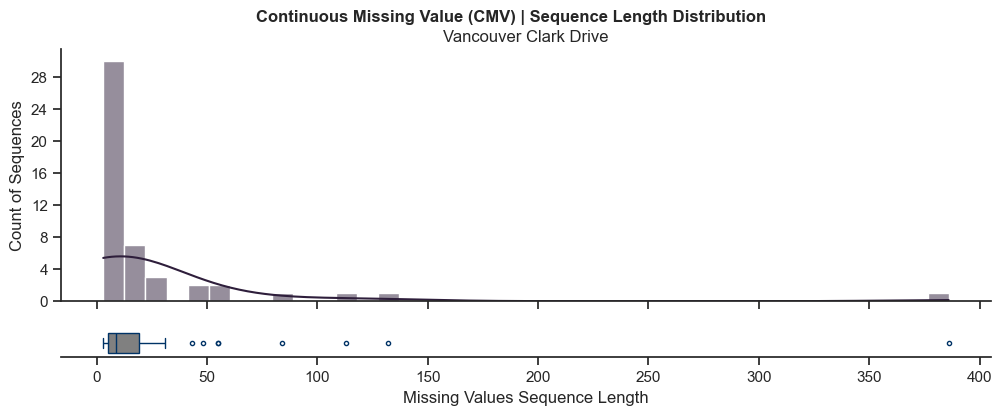

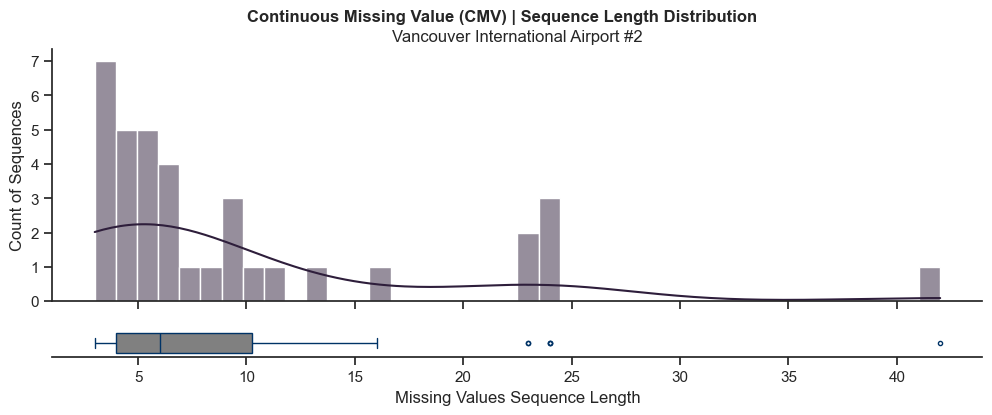

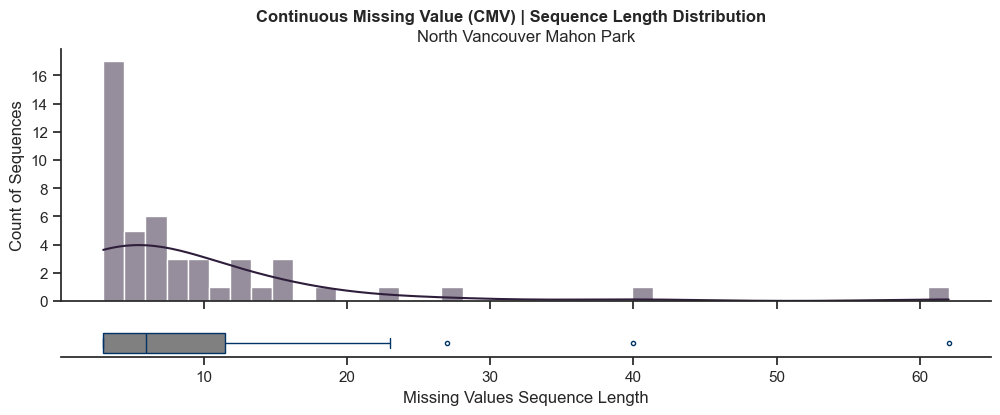

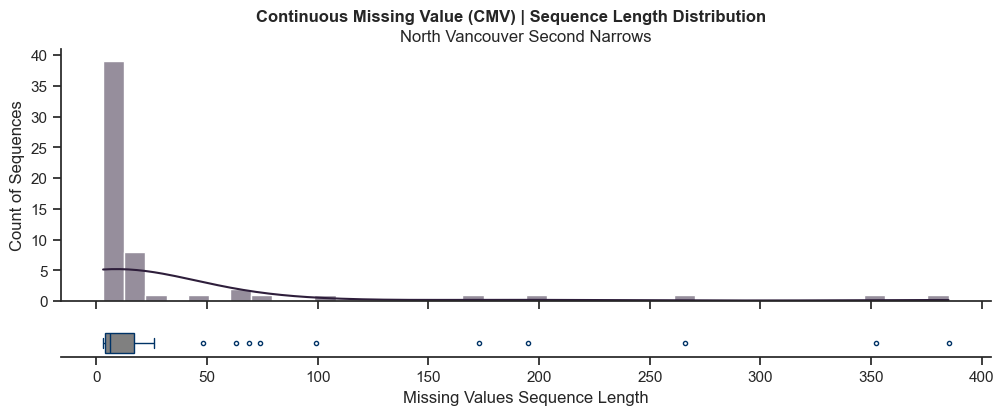

In [15]:
# Distribution of CMV Sequence Length
for station in stations:
    _, (ax_hist, ax_box) = plt.subplots(
        2,
        sharex=True,
        gridspec_kw={"height_ratios": (.9, .10)},
        figsize=(12,4)
    )

    plot_title = station[:-5].replace('_', ' ')
    cmv_counts = metadata[station].loc[metadata[station]['isCMV'] == 1, 'nan_count'].to_list()

    sns.histplot(x=cmv_counts, kde=True, bins=40, ax=ax_hist)
    sns.boxplot(x=cmv_counts, width=0.7, color='0.5', linecolor='#003366', flierprops={'marker': '.'}, ax=ax_box)

    ax_hist.set(title=plot_title, ylabel=f'Count of Sequences')
    ax_hist.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.suptitle('Continuous Missing Value (CMV) | Sequence Length Distribution',
                 fontweight='bold',
                 fontsize=12)
    ax_box.set(yticks=[], xlabel='Missing Values Sequence Length')
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)

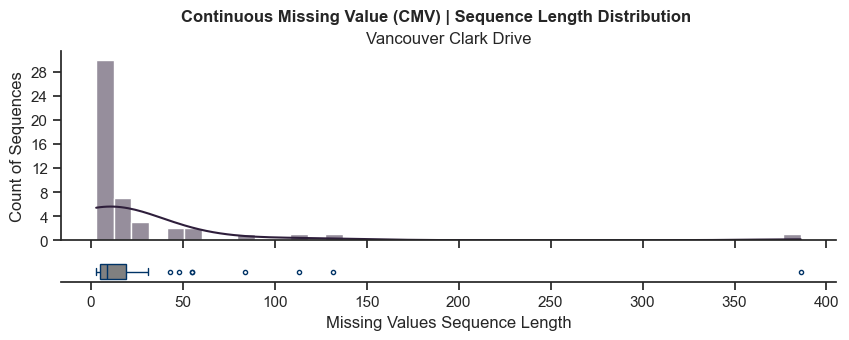

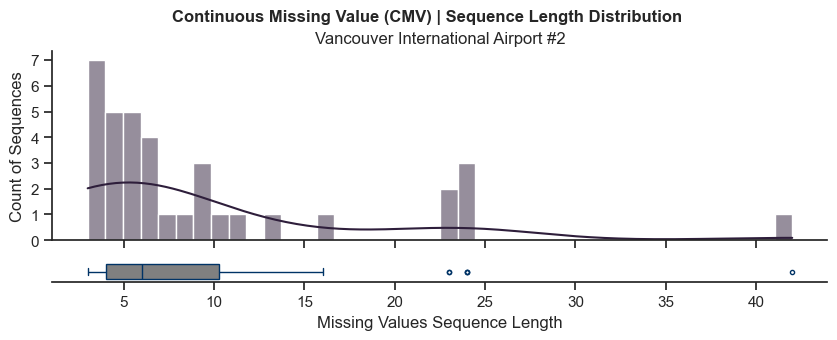

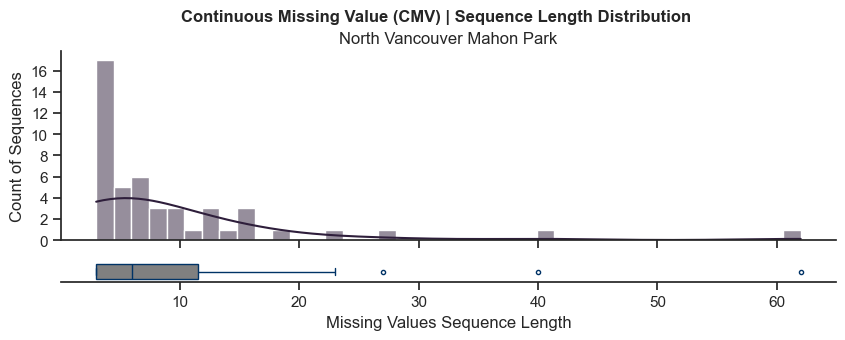

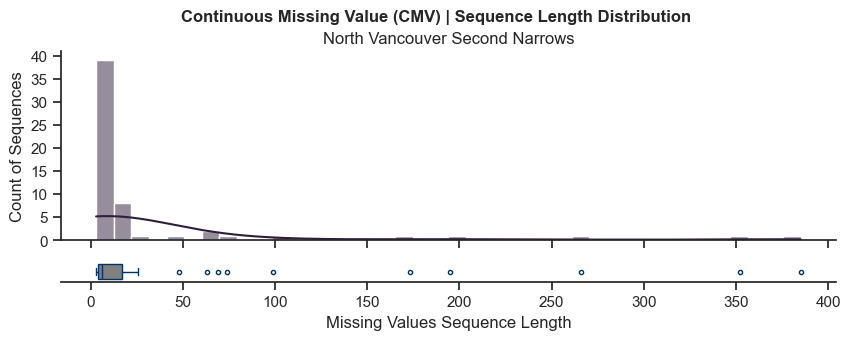

In [16]:
# Distribution of CMV Sequence Length
for station in stations:
    _, (ax_hist, ax_box) = plt.subplots(
        2,
        sharex=True,
        gridspec_kw={"height_ratios": (.9, .10)},
        figsize=(10,3)
    )

    plot_title = station[:-5].replace('_', ' ')
    cmv_counts = metadata[station].loc[metadata[station]['isCMV'] == 1, 'nan_count'].to_list()

    sns.histplot(x=cmv_counts, kde=True, bins=40, ax=ax_hist)
    sns.boxplot(x=cmv_counts, width=0.7, color='0.5', linecolor='#003366', flierprops={'marker': '.'}, ax=ax_box)

    ax_hist.set(title=plot_title, ylabel=f'Count of Sequences')
    ax_hist.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.suptitle('Continuous Missing Value (CMV) | Sequence Length Distribution',
                 y=1.02,
                 fontweight='bold',
                 fontsize=12)
    ax_box.set(yticks=[], xlabel='Missing Values Sequence Length')
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)

### Generating Artificial Missing Data
Artificially missing data will be generated to evaluate imputation methods.

In [17]:
%load_ext autoreload
%autoreload 2
from tshelpers.subset import subset_interval, create_missing
from tshelpers.plot import plot_sequence, plot_compare, plot_missing
from tshelpers.metrics import rmse_score, mae_score

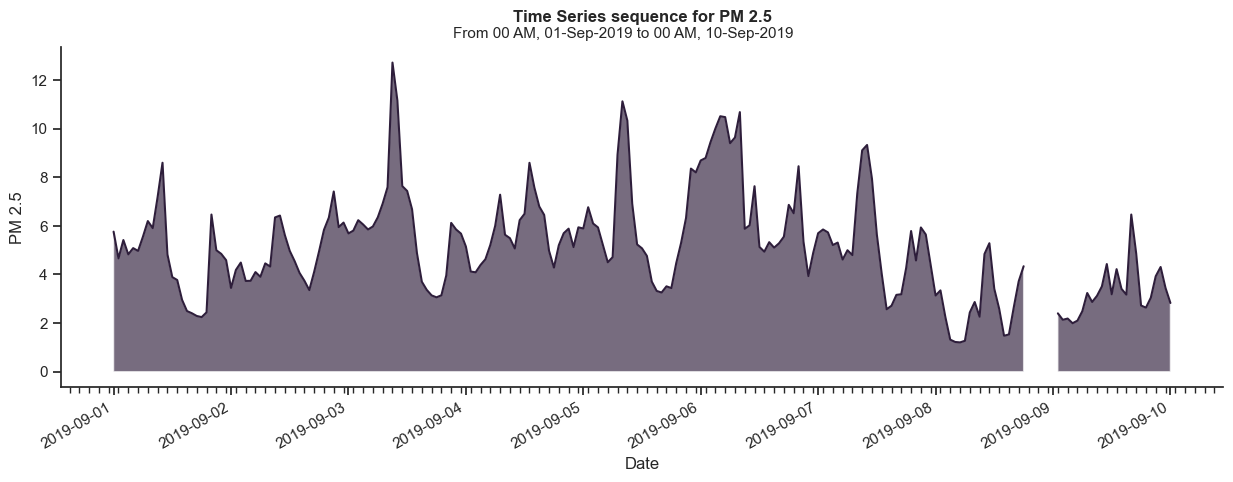

In [18]:
station_subset = master_df[master_df["Station"] == "North_Vancouver_Mahon_Park_PM25"]

subset, subset_missing = create_missing(
    data=station_subset,
    value="PM 2.5",
    start=datetime(2019, 9, 1),
    end=datetime(2019, 9, 10),
    missing_length=6,
    padding=24,
    missing_index="end",
)

plot_sequence(data=subset_missing, value="PM 2.5")

In [19]:
subset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 217 entries, 2019-09-01 00:00:00 to 2019-09-10 00:00:00
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Station     217 non-null    object 
 1   PM 2.5      217 non-null    float64
 2   isMissing   217 non-null    int64  
 3   seqMissing  217 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 8.5+ KB


In [20]:
subset_missing.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 217 entries, 2019-09-01 00:00:00 to 2019-09-10 00:00:00
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Station     217 non-null    object 
 1   PM 2.5      211 non-null    float64
 2   isMissing   217 non-null    int64  
 3   seqMissing  217 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 8.5+ KB


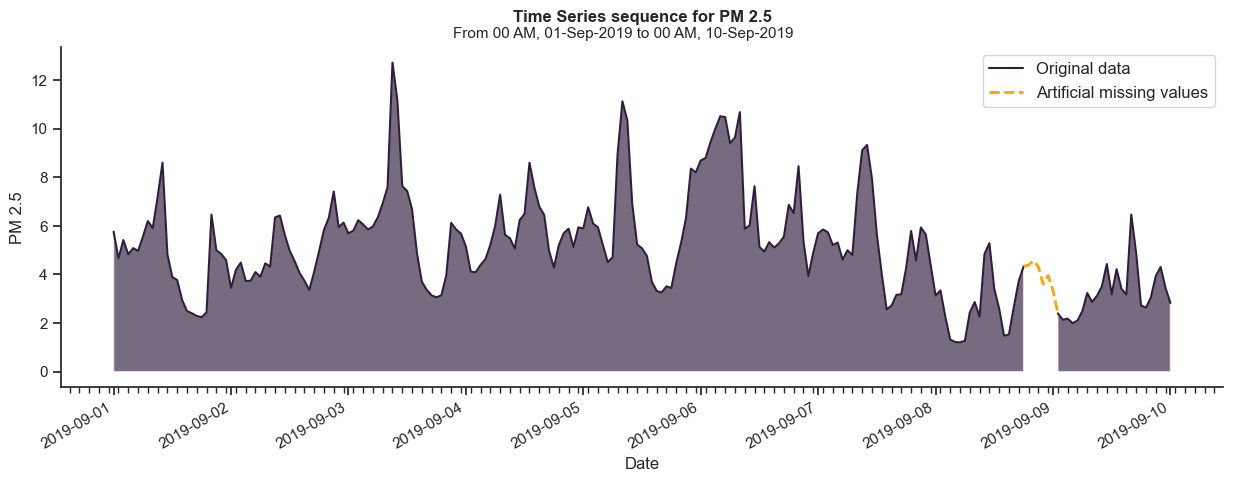

In [21]:
plot_compare(
    data=subset,                            # Subset to plot
    data_missing=subset_missing,            # Subset with missing values to plot
    value="PM 2.5",                         # Variable to plot from subset
    value_missing="PM 2.5",                 # Variable to plot from subset_missing
    missing_only=True,                      # Plt only the section with missing values from subset_missing
    start=datetime(2019, 9, 1),
    end=datetime(2019, 9, 10),
    fill=True,
    data_label="Artificial missing values", # Label for subset
    data_missing_label="Original data",     # Label for subset_missing
)

## Imputation of short sequences [1h, 2h]
* Short sequences with 2 or less subsequent data points missing
* Testing between cubic spline and linear imputation

### Subsetting intervals for experimentation
Defining candidate subsets to experiment with imputation methods.

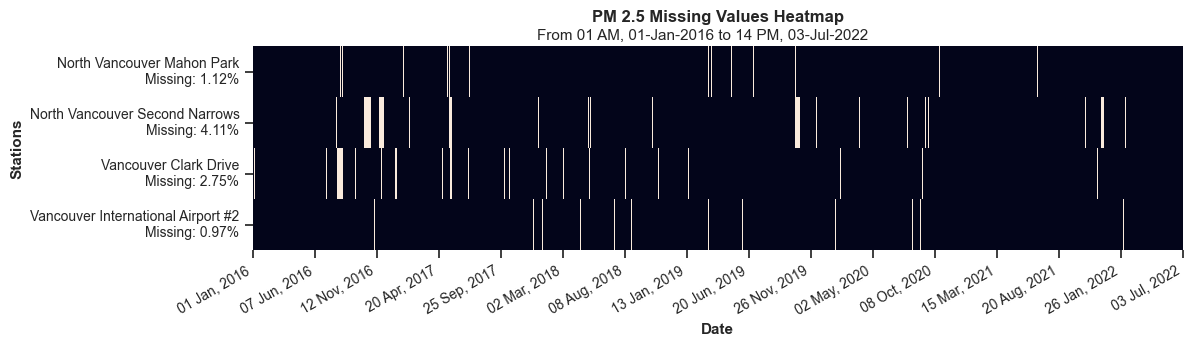

In [22]:
plot_missing(master_df.pivot(columns="Station", values="PM 2.5"))

In [23]:
# Looking for months without missing values
months_complete = {}
for station in stations:
    months_complete[station] = []
    station_subset = master_df[master_df["Station"] == station]
    for year in range (2016, 2022):
        if year == 2022:
            range_max = 7 # Limiting upper range for 2022 as data goes up to July
        else:
            range_max = 13
        for month in range(1, range_max):
            if month == 12:
                subset = station_subset[datetime(year, month, 1, 1): datetime(year, month, 31, 23)]
            else:
                subset = station_subset[datetime(year, month, 1, 1): datetime(year, month+1, 1)]
            if subset['PM 2.5'].isna().sum() == 0:
                months_complete[station].append((month, year))

for station in months_complete:
    print(f"{station} has {len(months_complete[station])} complete months:\n{months_complete[station]}\n")

Vancouver_Clark_Drive_PM25 has 3 complete months:
[(4, 2016), (10, 2016), (2, 2019)]

Vancouver_International_Airport_#2_PM25 has 3 complete months:
[(4, 2016), (7, 2016), (4, 2019)]

North_Vancouver_Mahon_Park_PM25 has 5 complete months:
[(1, 2016), (4, 2016), (6, 2016), (6, 2017), (2, 2018)]

North_Vancouver_Second_Narrows_PM25 has 9 complete months:
[(2, 2016), (6, 2016), (7, 2016), (3, 2017), (4, 2017), (9, 2017), (2, 2019), (4, 2019), (6, 2019)]



In [24]:
# Experimental subsets
exp_subsets = {}

for station in months_complete:
    exp_subsets[station] = {}
    for months in months_complete[station]: # Iterating on list of tuples (month, year) | (4, 2016)
        month = months[0]
        year = months[1]
        if month == 12:
            next_month = 1
            next_year = year+1
        else:
            next_month = month+1
            next_year = year
        exp_subsets[station][f'{month}-{year}'] = master_df[master_df["Station"] == station][
            datetime(year, month, 1):datetime(next_year, next_month, 1)
        ]

In [25]:
for station in exp_subsets:
    print(f'{station}:\n {exp_subsets[station].keys()}\n')

Vancouver_Clark_Drive_PM25:
 dict_keys(['4-2016', '10-2016', '2-2019'])

Vancouver_International_Airport_#2_PM25:
 dict_keys(['4-2016', '7-2016', '4-2019'])

North_Vancouver_Mahon_Park_PM25:
 dict_keys(['1-2016', '4-2016', '6-2016', '6-2017', '2-2018'])

North_Vancouver_Second_Narrows_PM25:
 dict_keys(['2-2016', '6-2016', '7-2016', '3-2017', '4-2017', '9-2017', '2-2019', '4-2019', '6-2019'])



In [26]:
exp_subsets['North_Vancouver_Mahon_Park_PM25']['1-2016'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2016-01-01 01:00:00 to 2016-02-01 00:00:00
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Station     744 non-null    object 
 1   PM 2.5      744 non-null    float64
 2   isMissing   744 non-null    int64  
 3   seqMissing  744 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 29.1+ KB


### Experimentation method
Backwards missing value generation.

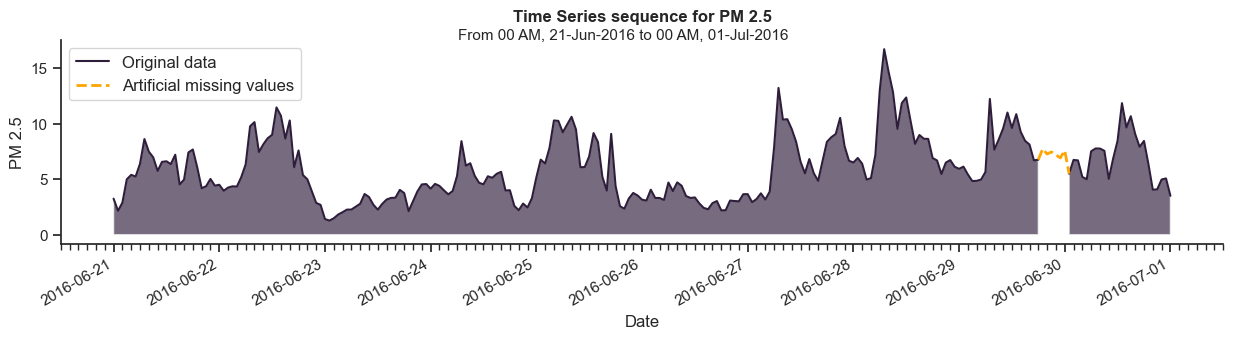

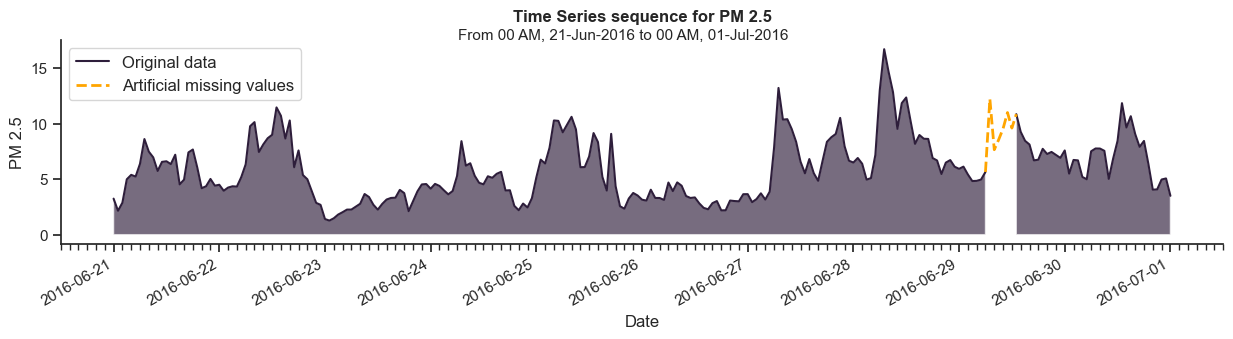

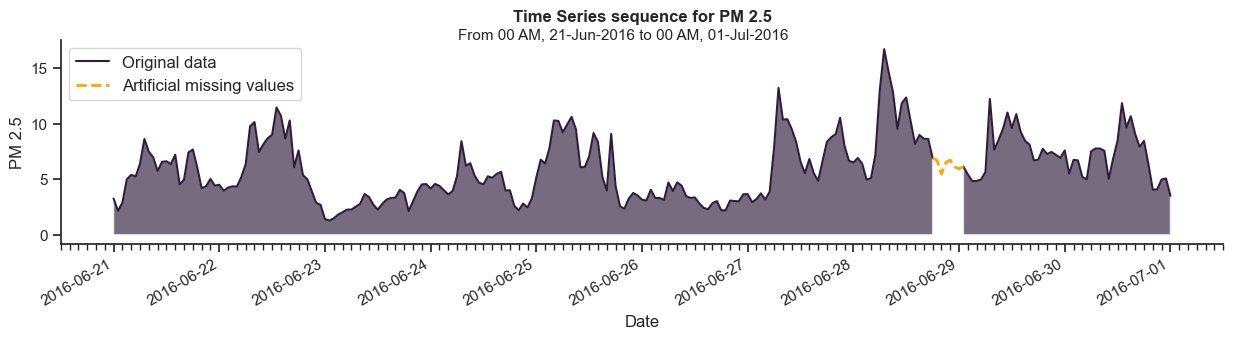

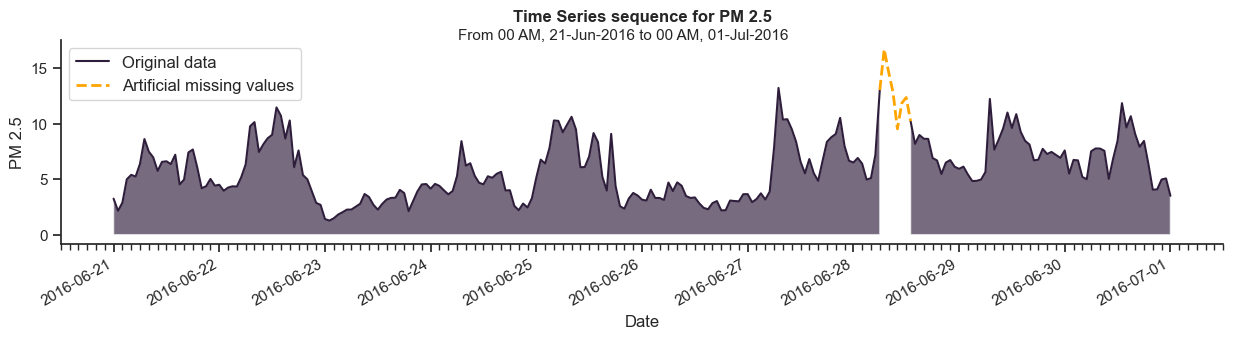

In [27]:
# Implementation example iterating through different paddings
paddings = [24, 36, 48, 60]

for padding in paddings:
    subset, subset_missing = create_missing(
        data=station_subset,
        value="PM 2.5",
        start=datetime(2016, 6, 21),
        end=datetime(2016, 7, 1),
        missing_length=6,
        padding=padding,
        missing_index="end",
    )
    plot_compare(
        subset,
        subset_missing,
        value="PM 2.5",
        value_missing="PM 2.5",
        missing_only=True,
        data_label="Artificial missing values",
        data_missing_label="Original data",
        figsize=(15, 3)
    )

Imputation example with linear interpolation

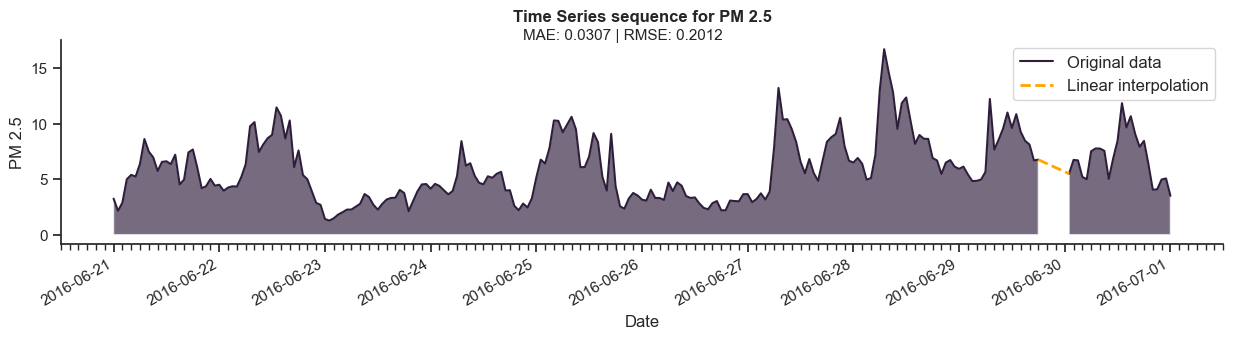

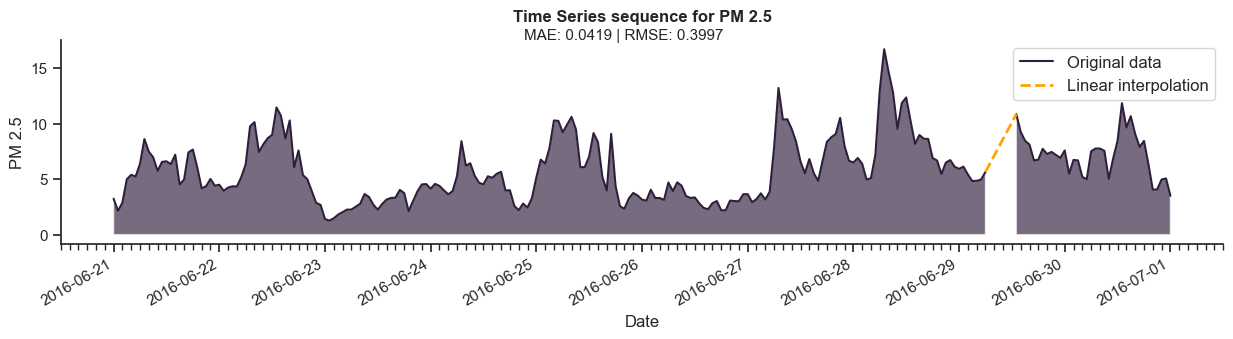

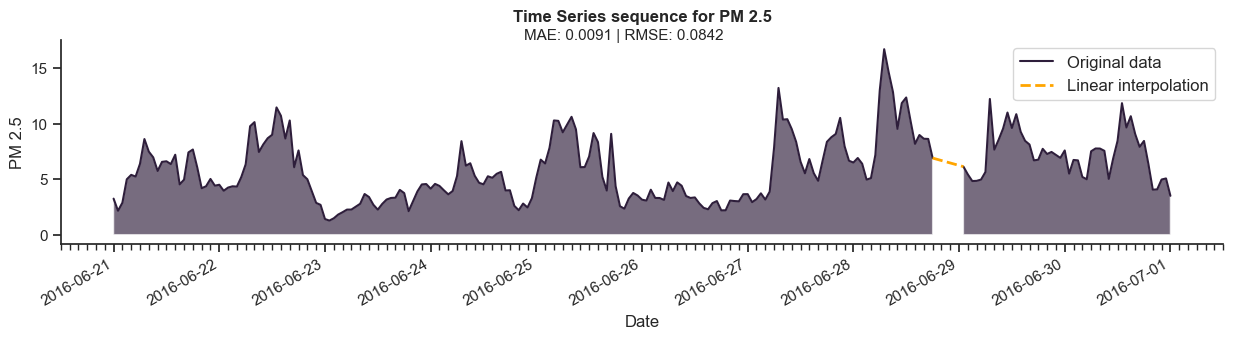

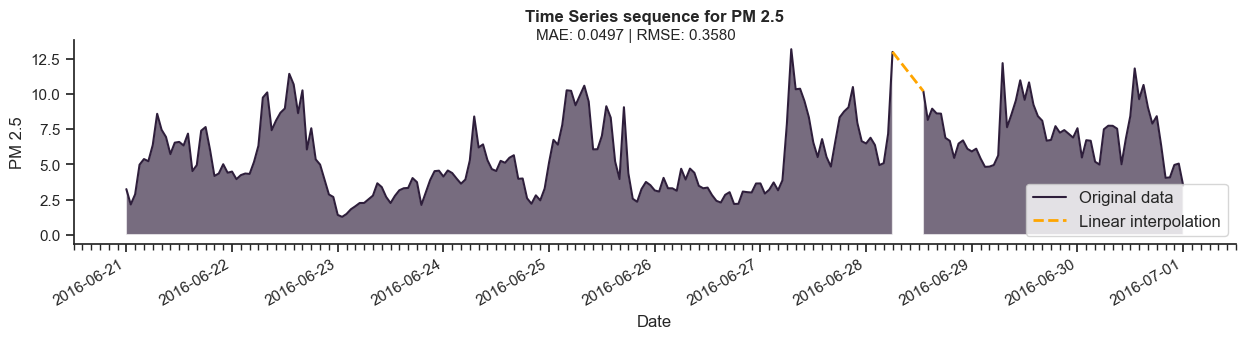

In [28]:
# Implementation example with linear interpolation:
for padding in paddings:
    subset, subset_missing = create_missing(
        data=station_subset,
        value="PM 2.5",
        start=datetime(2016, 6, 21),
        end=datetime(2016, 7, 1),
        missing_length=6,
        padding=padding,
        missing_index="end",
    )

    subset_linear = subset.copy()
    subset_linear["PM 2.5"] = (
        subset_missing["PM 2.5"].interpolate(method="linear").tolist()
    )
    
    plot_compare(
        subset_linear,
        subset_missing,
        value="PM 2.5",
        value_missing="PM 2.5",
        missing_only=True,
        data_label="Linear interpolation",
        data_missing_label="Original data",
        plot_sup_title=f"MAE: {mae_score(subset, subset_linear, value='PM 2.5', verbose=False):.4f}\
 | RMSE: {rmse_score(subset, subset_linear, value='PM 2.5', verbose=False):.4f}",
        figsize=(15, 3)
    )

Imputation example with cubic spline

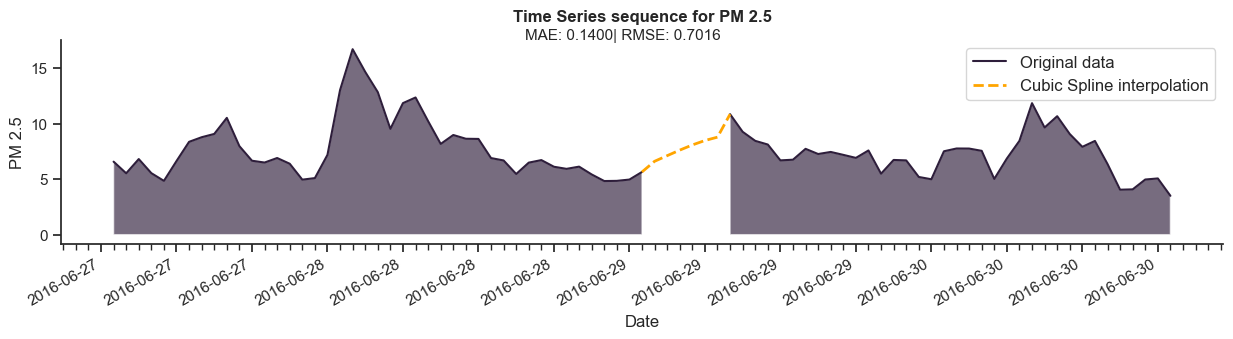

In [29]:
# Cubic spline interpolation - Pandas Series.interpolate
subset, subset_missing = create_missing(
    data=station_subset,
    value='PM 2.5',
    start=datetime(2016, 6, 27, 12),
    end=datetime(2016, 7, 1),
    missing_length=6,
    padding=36, #24, 36, 48, 60
    missing_index='end',
)

subset_spline = subset.copy()
subset_spline["PM 2.5"] = (
    subset_missing["PM 2.5"].interpolate(method="spline", order=3).tolist()
)

plot_compare(
    subset_spline,
    subset_missing,
    value="PM 2.5",
    value_missing="PM 2.5",
    missing_only=True,
    data_label="Cubic Spline interpolation",
    data_missing_label="Original data",
    plot_sup_title=f"MAE: {mae_score(subset, subset_spline, value='PM 2.5', verbose=False):.4f}\
| RMSE: {rmse_score(subset, subset_spline, value='PM 2.5', verbose=False):.4f}",
    figsize=(15, 3)
)

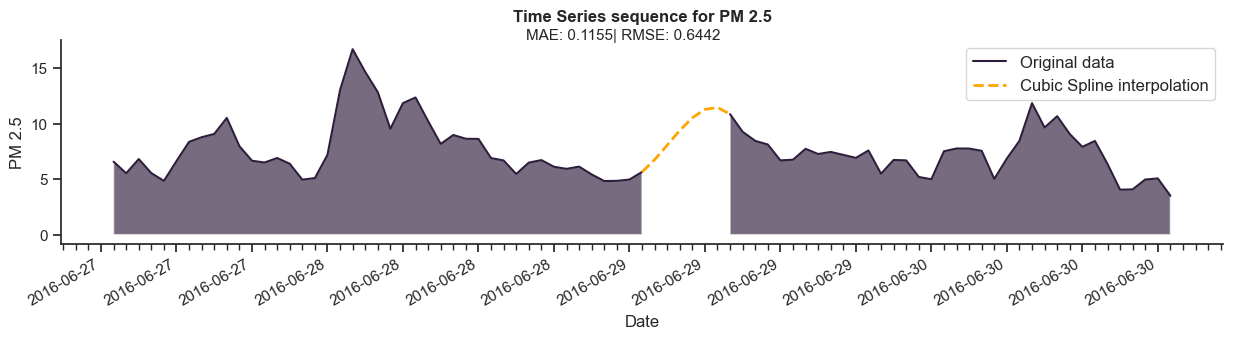

In [30]:
# Cubic spline interpolation - Scipy interpolate.splrep
pd.options.mode.chained_assignment = None # Shutdown warnings when working on slices of dataframes
from scipy import interpolate

subset, subset_missing = create_missing(
    data=station_subset,
    value='PM 2.5',
    start=datetime(2016, 6, 27, 12),
    end=datetime(2016, 7, 1),
    missing_length=6,
    padding=36, #24, 36, 48, 60
    missing_index='end',
)

subset_spline = subset.copy()
# Indexing missing values
missing_idx = np.where(subset_missing["PM 2.5"].isna())[0].tolist()

# Indexing boundary values at t-2, t-1, t+1, and t+2
boundary_idx = []
for idx in range(min(missing_idx)-2, max(missing_idx)+3):
    if idx not in missing_idx:
        boundary_idx.append(idx)
boundary = subset_missing["PM 2.5"][boundary_idx].tolist()

# Fitting cubic spline
cubic_spline = interpolate.splrep(x=boundary_idx, y=boundary, k=3)
imputed = interpolate.splev(missing_idx, cubic_spline)

subset_spline["PM 2.5"][missing_idx] = imputed

plot_compare(
    subset_spline,
    subset_missing,
    value="PM 2.5",
    value_missing="PM 2.5",
    missing_only=True,
    data_label="Cubic Spline interpolation",
    data_missing_label="Original data",
    plot_sup_title=f"MAE: {mae_score(subset, subset_spline, value='PM 2.5', verbose=False):.4f}\
| RMSE: {rmse_score(subset, subset_spline, value='PM 2.5', verbose=False):.4f}",
    figsize=(15, 3)
)

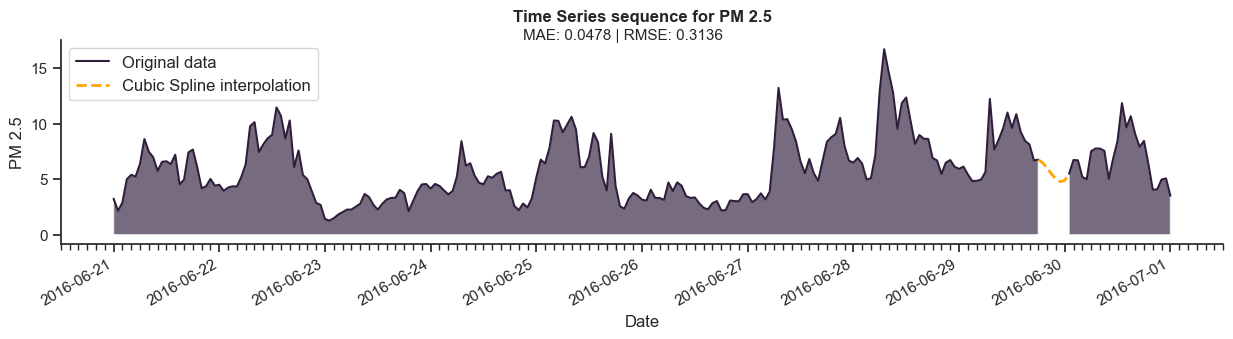

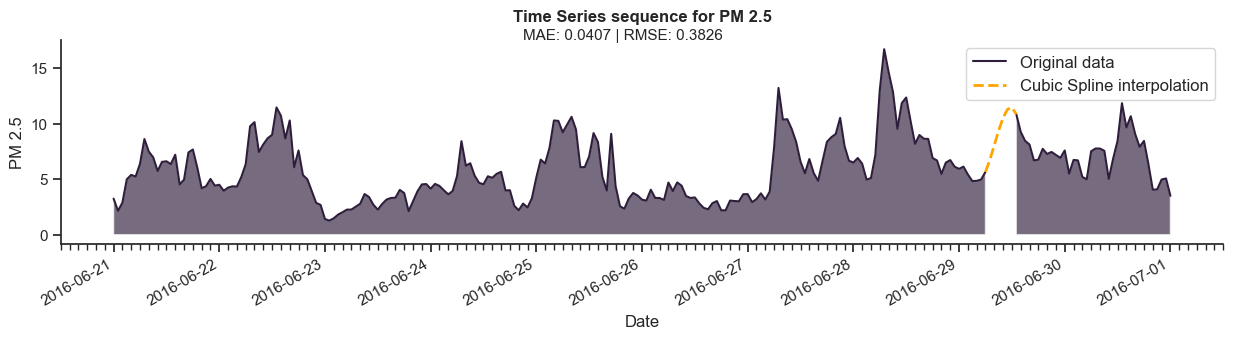

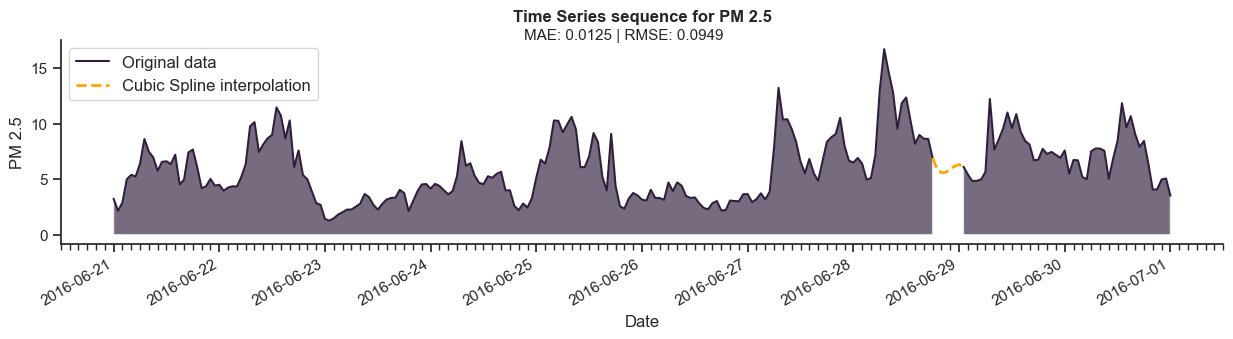

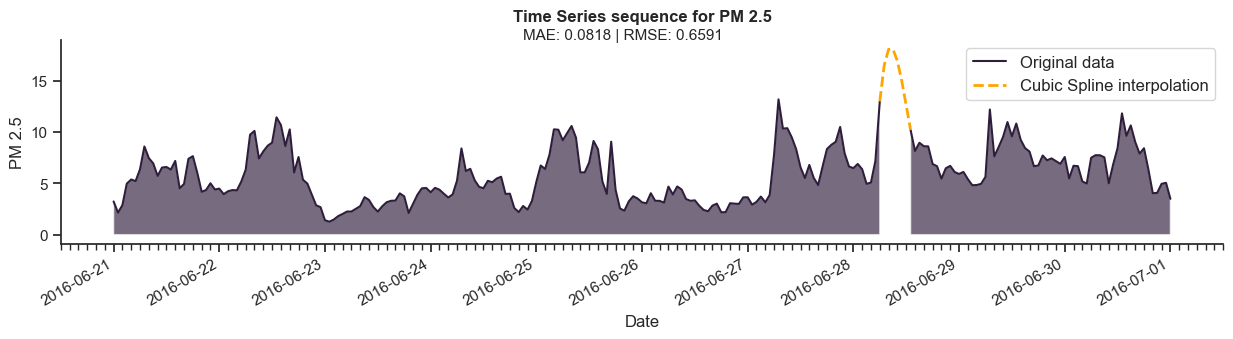

In [31]:
# Implementation example with cubic spline interpolation
for padding in paddings:
    subset, subset_missing = create_missing(
        data=station_subset,
        value="PM 2.5",
        start=datetime(2016, 6, 21),
        end=datetime(2016, 7, 1),
        missing_length=6,
        padding=padding,
        missing_index="end",
    )

    subset_spline = subset.copy()
    # Indexing missing values
    missing_idx = np.where(subset_missing["PM 2.5"].isna())[0].tolist()

    # Indexing boundary values at t-2, t-1, t+1, and t+2
    boundary_idx = []
    for idx in range(min(missing_idx)-2, max(missing_idx)+3):
        if idx not in missing_idx:
            boundary_idx.append(idx)
    boundary = subset_missing["PM 2.5"][boundary_idx].tolist()

    # Fitting cubic spline
    cubic_spline = interpolate.splrep(x=boundary_idx, y=boundary, k=3)
    imputed = interpolate.splev(missing_idx, cubic_spline)

    subset_spline["PM 2.5"][missing_idx] = imputed

    plot_compare(
        subset_spline,
        subset_missing,
        value="PM 2.5",
        value_missing="PM 2.5",
        missing_only=True,
        data_label="Cubic Spline interpolation",
        data_missing_label="Original data",
        plot_sup_title=f"MAE: {mae_score(subset, subset_spline, value='PM 2.5', verbose=False):.4f}\
 | RMSE: {rmse_score(subset, subset_spline, value='PM 2.5', verbose=False):.4f}",
        figsize=(15, 3)
    )

>Ref.: _Carl de Boor, “A Practical Guide to Splines”, Springer-Verlag, 1978. pp 40-50_

### Linear and Cubic Spline imputation of Short Sequences
* Iteration through missing lengths ∈ (1h, 2h)
* For each subset, generate missing lengths on every hour, from right to left
* Measure Root-Mean-Square Error (RMSE) and Mean-Absolute Error (MAE) against original data

In [32]:
%%time
# Iterate through stations, then subsets to evaluate linear interpolation vs. cubic spline
from tqdm import tqdm

# Artificial missing values function parameters
create_missing_args = {
    "value": "PM 2.5",
    "missing_index": "end"
}

imputation_results = {}
for station in (pbar := tqdm(exp_subsets)):
    pbar.set_description(f"Processing station {station}")
    for station_subset in exp_subsets[station]:
        imputation_step = str(station + "_" + station_subset)
        imputation_results[imputation_step] = {}
        imputation_results[imputation_step]["RMSE_Cubic"] = []
        imputation_results[imputation_step]["RMSE_Linear"] = []
        imputation_results[imputation_step]["MAE_Cubic"] = []
        imputation_results[imputation_step]["MAE_Linear"] = []
        imputation_results[imputation_step]["Missing_Length"] = []        
        # Generating backwards missing intervals
        paddings = [i for i in range(2, len(exp_subsets[station][station_subset]))]
        for padding in paddings:
            # Creating missing interval with length = 1 and length = 2
            for length in [1, 2]:
                subset, subset_missing = create_missing(
                    **create_missing_args,
                    data=exp_subsets[station][station_subset],
                    padding=padding,
                    missing_length=length
                )
                ### Cubic spline
                subset_spline = subset.copy()
                missing_idx = np.where(subset_missing["PM 2.5"].isna())[0].tolist()

                # Indexing boundary values at t-2, t-1, t+1, and t+2
                boundary_idx = []
                for idx in range(min(missing_idx)-2, max(missing_idx)+3):
                    if idx not in missing_idx:
                        boundary_idx.append(idx)
                boundary = subset_missing["PM 2.5"][boundary_idx].tolist()

                # Fitting cubic spline
                cubic_spline = interpolate.splrep(x=boundary_idx, y=boundary, k=3)
                imputed = interpolate.splev(missing_idx, cubic_spline)
                subset_spline["PM 2.5"][missing_idx] = imputed

                # Evaluating cubic spline
                rmse_cubic = rmse_score(subset, subset_spline, value="PM 2.5", verbose=False)
                mae_cubic = mae_score(subset, subset_spline, value="PM 2.5", verbose=False)
                imputation_results[imputation_step]["RMSE_Cubic"].append(rmse_cubic)
                imputation_results[imputation_step]["MAE_Cubic"].append(mae_cubic)

                ### Linear interpolation
                subset_linear = subset.copy()
                subset_linear["PM 2.5"] = subset_missing["PM 2.5"].interpolate(method="linear", inplace=False).tolist()

                # Evaluating linear interpolation
                rmse_linear = rmse_score(subset, subset_linear, value="PM 2.5", verbose=False)
                mae_linear = mae_score(subset, subset_linear, value="PM 2.5", verbose=False)
                imputation_results[imputation_step]["RMSE_Linear"].append(rmse_linear)
                imputation_results[imputation_step]["MAE_Linear"].append(mae_linear)
                imputation_results[imputation_step]["Missing_Length"].append(length)

Processing station North_Vancouver_Second_Narrows_PM25: 100%|██████████| 4/4 [01:09<00:00, 17.40s/it]    

CPU times: user 1min 9s, sys: 77.2 ms, total: 1min 9s
Wall time: 1min 9s


In [33]:
# Concatenating master dataframe
subsets = []
for subset in imputation_results.keys():
    subsets.append(pd.DataFrame(imputation_results[subset]))

metrics_df = pd.concat(subsets).reset_index(drop=True)
metrics_df.round(6).head()

RMSE_Cubic  RMSE_Linear  MAE_Cubic  MAE_Linear  Missing_Length
0    0.033493     0.024058   0.001247    0.000896               1
1    0.050441     0.051899   0.001883    0.002001               2
2    0.050351     0.050928   0.001875    0.001897               1
3    0.059907     0.051147   0.002644    0.001921               2
4    0.026684     0.025138   0.000994    0.000936               1

### RMSE and MAE results

In [34]:
metrics_df.groupby("Missing_Length").describe(percentiles=[]).T.round(5)

Missing_Length               1            2
RMSE_Cubic  count  14331.00000  14331.00000
            mean       0.03324      0.06474
            std        0.04989      0.08141
            min        0.00001      0.00024
            50%        0.01754      0.03899
            max        0.80107      1.29857
RMSE_Linear count  14331.00000  14331.00000
            mean       0.03193      0.05956
            std        0.04772      0.07408
            min        0.00000      0.00000
            50%        0.01698      0.03662
            max        0.78733      1.38782
MAE_Cubic   count  14331.00000  14331.00000
            mean       0.00124      0.00314
            std        0.00187      0.00399
            min        0.00000      0.00001
            50%        0.00065      0.00186
            max        0.03088      0.06828
MAE_Linear  count  14331.00000  14331.00000
            mean       0.00119      0.00288
            std        0.00178      0.00359
            min        0.00000      0.00000
            50%        0.00063      0.00176
            max        0.03002      0.07297

In [35]:
# Melting dataframes for boxplot visualizations
RMSE_melt_df = pd.melt(metrics_df[["RMSE_Cubic", "RMSE_Linear", "Missing_Length"]].rename(columns=lambda x: x.split("_")[1]),
                      id_vars="Length",
                      var_name="Method",
                      value_name="RMSE")

MAE_melt_df = pd.melt(metrics_df[["MAE_Cubic", "MAE_Linear", "Missing_Length"]].rename(columns=lambda x: x.split("_")[1]),
                      id_vars="Length",
                      var_name="Method",
                      value_name="MAE")

display(RMSE_melt_df.head())
print(RMSE_melt_df.shape)
display(MAE_melt_df.head())
print(MAE_melt_df.shape)

Length Method      RMSE
0       1  Cubic  0.033493
1       2  Cubic  0.050441
2       1  Cubic  0.050351
3       2  Cubic  0.059907
4       1  Cubic  0.026684

(57324, 3)


Length Method       MAE
0       1  Cubic  0.001247
1       2  Cubic  0.001883
2       1  Cubic  0.001875
3       2  Cubic  0.002644
4       1  Cubic  0.000994

(57324, 3)


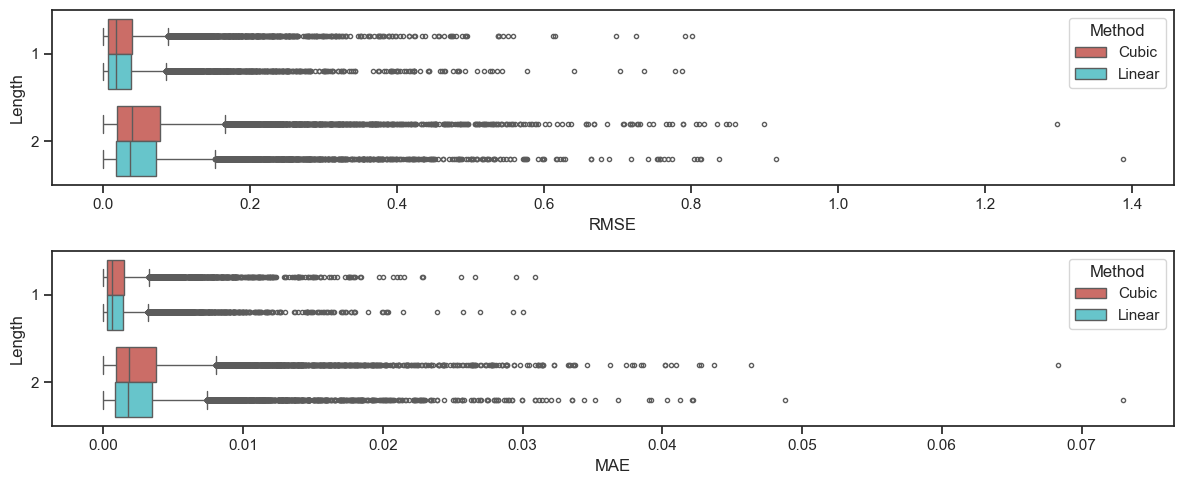

In [36]:
# Boxplot of metrics results
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
box_plot_args = {
    "y": "Length",
    "hue": "Method",
    "palette": "hls",
    "orient": "h",
    "flierprops": {'marker': '.'}
}
sns.boxplot(RMSE_melt_df,
            x="RMSE",
            ax=axs[0],
            **box_plot_args)
sns.boxplot(MAE_melt_df,
            x="MAE",
            ax=axs[1],
            **box_plot_args)
fig.tight_layout()
plt.show()

RMSE metrics without outliers: (56139, 3). Outliers removed: 1185.
MAE metrics without outliers: (56148, 3). Outliers removed: 1176.


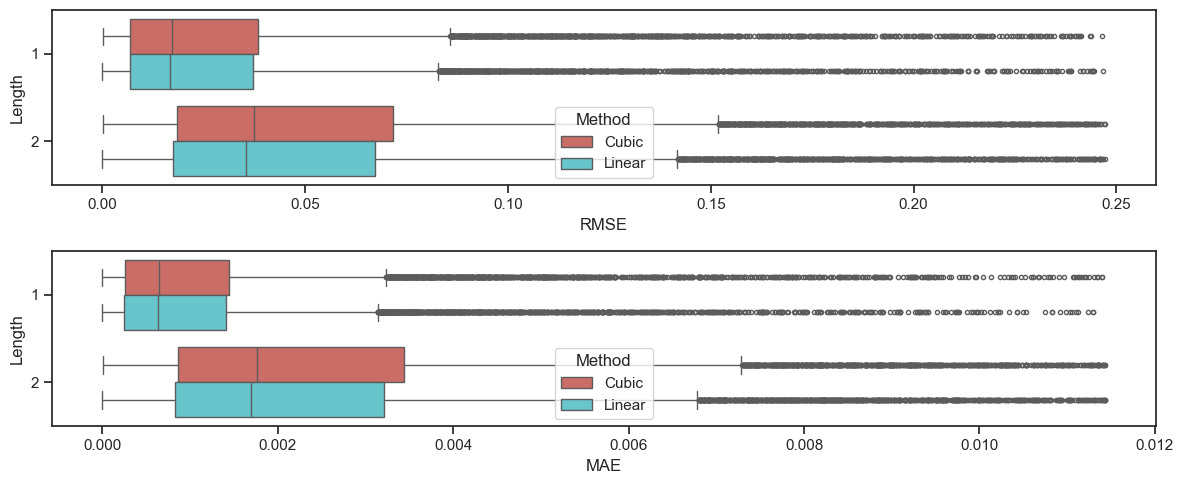

In [37]:
# Metrics without outliers
RMSE_melt_df_noout = RMSE_melt_df[(np.abs(stats.zscore(RMSE_melt_df["RMSE"])) < 3)]
MAE_melt_df_noout = MAE_melt_df[(np.abs(stats.zscore(MAE_melt_df["MAE"])) < 3)]
print(f"RMSE metrics without outliers: {RMSE_melt_df_noout.shape}.\
 Outliers removed: {MAE_melt_df.shape[0] - RMSE_melt_df_noout.shape[0]}.")
print(f"MAE metrics without outliers: {MAE_melt_df_noout.shape}.\
 Outliers removed: {MAE_melt_df.shape[0] - MAE_melt_df_noout.shape[0]}.")

# Boxplot of metrics results without outliers
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
sns.boxplot(RMSE_melt_df_noout,
            x="RMSE",
            ax=axs[0],
            **box_plot_args)
sns.boxplot(MAE_melt_df_noout,
            x="MAE",
            ax=axs[1],
            **box_plot_args)
fig.tight_layout()
plt.show()

### Imputing short sequences [1h, 2h]
* Imputation of short sequences up to 2h with linear method

Missing  Missing %
Station           0       0.00
PM 2.5         4958       2.22
isMissing         0       0.00
seqMissing        0       0.00

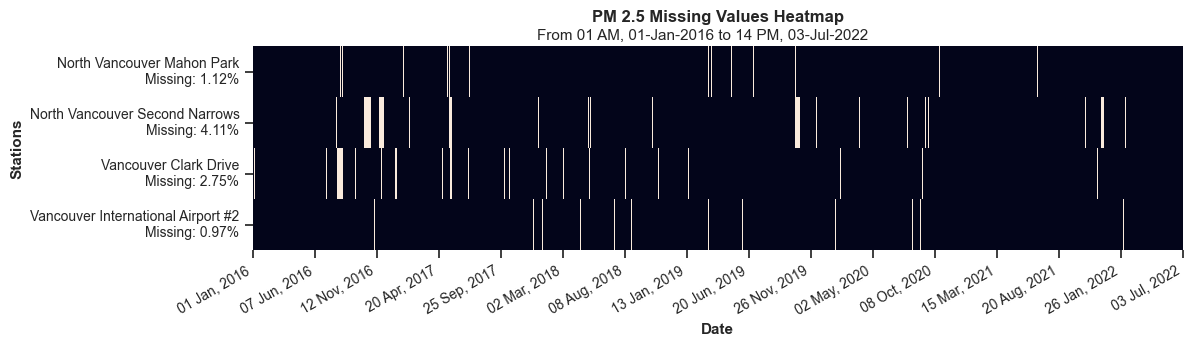

In [38]:
# Missing summary before linear interpolation imputation
missing_tot = master_df.isna().sum()
missing_pct = round(master_df.isna().sum()/master_df.count()*100, 2)
missing_summary = pd.concat([missing_tot, missing_pct], axis=1)
missing_summary.rename(columns={0: 'Missing', 1: 'Missing %'}, inplace=True)
display(missing_summary)

plot_missing(master_df.pivot(columns="Station", values="PM 2.5"))

Missing  Missing %
Station           0       0.00
PM 2.5         4175       1.86
isMissing         0       0.00
seqMissing        0       0.00

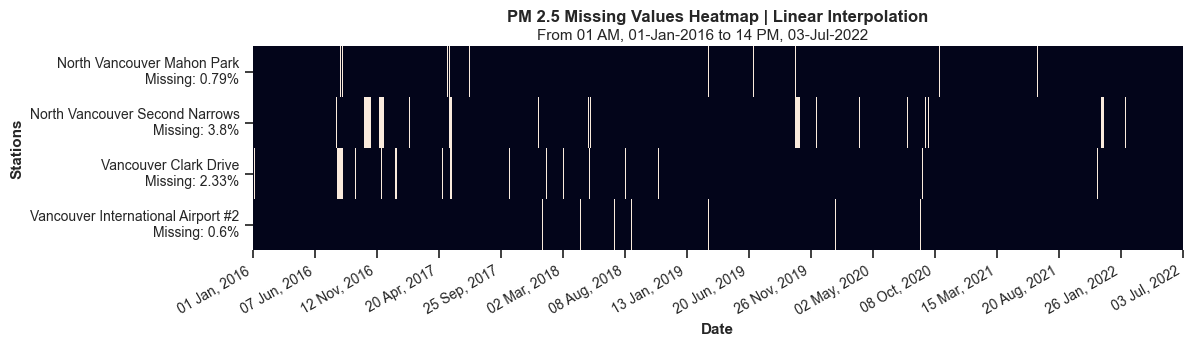

In [39]:
# Linear interpolation imputation
master_df.loc[master_df["seqMissing"] <= 2, "PM 2.5"] = master_df.loc[master_df["seqMissing"] <= 2, "PM 2.5"].interpolate()

# Missing summary
missing_tot = master_df.isna().sum()
missing_pct = round(master_df.isna().sum()/master_df.count()*100, 2)
missing_summary = pd.concat([missing_tot, missing_pct], axis=1)
missing_summary.rename(columns={0: 'Missing', 1: 'Missing %'}, inplace=True)
display(missing_summary)

plot_missing(master_df.pivot(columns="Station", values="PM 2.5"), plot_title="PM 2.5 Missing Values Heatmap | Linear Interpolation")

In [40]:
# Flag for interpolated values
master_df['isImputedInterpolation'] = 0
master_df.loc[(master_df['isMissing'] == 1) & (~master_df['PM 2.5'].isna()), 'isImputedInterpolation'] = 1

master_df[master_df['seqMissing'].isin([1, 2])]

Station     PM 2.5  \
DATE_PST                                                              
2016-01-05 09:00:00           Vancouver_Clark_Drive_PM25   6.407333   
2016-01-05 10:00:00           Vancouver_Clark_Drive_PM25   6.528667   
2016-01-06 10:00:00           Vancouver_Clark_Drive_PM25  14.106667   
2016-01-06 11:00:00           Vancouver_Clark_Drive_PM25  16.090333   
2016-02-02 14:00:00           Vancouver_Clark_Drive_PM25   5.272000   
...                                                  ...        ...   
2022-04-27 08:00:00  North_Vancouver_Second_Narrows_PM25   9.099740   
2022-05-10 08:00:00  North_Vancouver_Second_Narrows_PM25   4.874899   
2022-05-24 07:00:00  North_Vancouver_Second_Narrows_PM25   5.961384   
2022-06-06 13:00:00  North_Vancouver_Second_Narrows_PM25  11.050020   
2022-06-22 10:00:00  North_Vancouver_Second_Narrows_PM25   3.844814   

                     isMissing  seqMissing  isImputedInterpolation  
DATE_PST                                                            
2016-01-05 09:00:00          1           2                       1  
2016-01-05 10:00:00          1           2                       1  
2016-01-06 10:00:00          1           2                       1  
2016-01-06 11:00:00          1           2                       1  
2016-02-02 14:00:00          1           2                       1  
...                        ...         ...                     ...  
2022-04-27 08:00:00          1           1                       1  
2022-05-10 08:00:00          1           1                       1  
2022-05-24 07:00:00          1           1                       1  
2022-06-06 13:00:00          1           1                       1  
2022-06-22 10:00:00          1           1                       1  

[783 rows x 5 columns]

In [41]:
for station in stations:
    station_subset = master_df.loc[master_df["Station"] == station, ["PM 2.5"]]
    station_subset.reset_index(inplace=True)

    original_metadata = metadata[station]
    metadata[station] = {}
    metadata[station]['original'] = original_metadata
    metadata[station]['imputedIMV'] = count_sequences(station_subset, time='DATE_PST', value='PM 2.5')

In [42]:
metadata['North_Vancouver_Mahon_Park_PM25']['original']

seq_start_idx  seq_end_idx      seq_start_time        seq_end_time  \
0                0          830 2016-01-01 01:00:00 2016-02-04 15:00:00   
1              831          831 2016-02-04 16:00:00 2016-02-04 16:00:00   
2              832         1140 2016-02-04 17:00:00 2016-02-17 13:00:00   
3             1141         1141 2016-02-17 14:00:00 2016-02-17 14:00:00   
4             1142         1977 2016-02-17 15:00:00 2016-03-23 10:00:00   
..             ...          ...                 ...                 ...   
394          56219        56411 2022-05-31 12:00:00 2022-06-08 12:00:00   
395          56412        56412 2022-06-08 13:00:00 2022-06-08 13:00:00   
396          56413        56742 2022-06-08 14:00:00 2022-06-22 07:00:00   
397          56743        56743 2022-06-22 08:00:00 2022-06-22 08:00:00   
398          56744        57013 2022-06-22 09:00:00 2022-07-03 14:00:00   

     not_nan_count  nan_count  isCMV  isIMV  
0              831          0      0      0  
1                0          1      0      1  
2              309          0      0      0  
3                0          1      0      1  
4              836          0      0      0  
..             ...        ...    ...    ...  
394            193          0      0      0  
395              0          1      0      1  
396            330          0      0      0  
397              0          1      0      1  
398            270          0      0      0  

[399 rows x 8 columns]

In [43]:
metadata['North_Vancouver_Mahon_Park_PM25']['imputedIMV']

seq_start_idx  seq_end_idx      seq_start_time        seq_end_time  \
0               0         1977 2016-01-01 01:00:00 2016-03-23 10:00:00   
1            1978         1991 2016-03-23 11:00:00 2016-03-24 00:00:00   
2            1992         4977 2016-03-24 01:00:00 2016-07-26 10:00:00   
3            4978         4990 2016-07-26 11:00:00 2016-07-26 23:00:00   
4            4991         5311 2016-07-27 00:00:00 2016-08-09 08:00:00   
..            ...          ...                 ...                 ...   
90          51175        55711 2021-11-02 08:00:00 2022-05-10 08:00:00   
91          55712        55714 2022-05-10 09:00:00 2022-05-10 11:00:00   
92          55715        56215 2022-05-10 12:00:00 2022-05-31 08:00:00   
93          56216        56218 2022-05-31 09:00:00 2022-05-31 11:00:00   
94          56219        57013 2022-05-31 12:00:00 2022-07-03 14:00:00   

    not_nan_count  nan_count  
0            1978          0  
1               0         14  
2            2986          0  
3               0         13  
4             321          0  
..            ...        ...  
90           4537          0  
91              0          3  
92            501          0  
93              0          3  
94            795          0  

[95 rows x 6 columns]

## Imputation of long sequences (>= 2h)
- FFT
- Linear Interpolation

In [44]:
# Candidate subsets to evaluate imputation method
for station in stations:
    print(f'{station}:')
    display(metadata[station]['imputedIMV'].sort_values('not_nan_count', ascending=False).head(3))

Vancouver_Clark_Drive_PM25:


seq_start_idx  seq_end_idx      seq_start_time        seq_end_time  \
74          31556        41063 2019-08-07 21:00:00 2020-09-07 00:00:00   
90          47749        51792 2021-06-12 14:00:00 2021-11-28 01:00:00   
76          41095        45021 2020-09-08 08:00:00 2021-02-18 22:00:00   

    not_nan_count  nan_count  
74           9508          0  
90           4044          0  
76           3927          0

Vancouver_International_Airport_#2_PM25:


seq_start_idx  seq_end_idx      seq_start_time        seq_end_time  \
48          35841        40926 2020-02-02 10:00:00 2020-09-01 07:00:00   
68          47749        51900 2021-06-12 14:00:00 2021-12-02 13:00:00   
16          12757        16807 2017-06-15 14:00:00 2017-12-01 08:00:00   

    not_nan_count  nan_count  
48           5086          0  
68           4152          0  
16           4051          0

North_Vancouver_Mahon_Park_PM25:


seq_start_idx  seq_end_idx      seq_start_time        seq_end_time  \
26          14924        21292 2017-09-13 21:00:00 2018-06-06 05:00:00   
90          51175        55711 2021-11-02 08:00:00 2022-05-10 08:00:00   
70          37628        42104 2020-04-16 21:00:00 2020-10-20 09:00:00   

    not_nan_count  nan_count  
26           6369          0  
90           4537          0  
70           4477          0

North_Vancouver_Second_Narrows_PM25:


seq_start_idx  seq_end_idx      seq_start_time        seq_end_time  \
24           13881        17511 2017-08-01 10:00:00 2017-12-30 16:00:00   
2             1760         5119 2016-03-14 09:00:00 2016-08-01 08:00:00   
108          48898        52020 2021-07-30 11:00:00 2021-12-07 13:00:00   

     not_nan_count  nan_count  
24            3631          0  
2             3360          0  
108           3123          0

In [45]:
from darts import TimeSeries
from darts.models import LinearRegressionModel
from darts.metrics import mae, rmse

In [46]:
# Auxiliar plotting function
def dart_plot(train, val, plot_title="Time Series Train/Validation Sets", pred=None, pred_label="predicted"):
    plt.figure(figsize=(12, 2.5))
    train.plot(label="training")
    val.plot(label="validation", linewidth=1, color="darkblue")
    if pred:
        pred.plot(label=pred_label, linewidth=1.5, color = "darkorange")
        plt.title(f"MAE: {mae(pred, val):.3f} | RMSE: {rmse(pred, val):.3f}", fontsize=10)
        plt.suptitle(plot_title, fontweight="bold", fontsize=11, y=1.04)
    else:
        plt.title(plot_title, fontweight="bold", fontsize=11)
    plt.legend()
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylabel("PM 2.5", fontsize=11)
    plt.xlabel("")
    sns.despine()
    plt.show()

In [47]:
exp_subset = master_df[master_df['Station'] == 'Vancouver_Clark_Drive_PM25']
exp_subset = exp_subset.loc[
    datetime(2019, 8, 8):datetime(2020, 9, 6),
    ['PM 2.5']
]
exp_subset

PM 2.5
DATE_PST                      
2019-08-08 00:00:00   9.478311
2019-08-08 01:00:00   8.098203
2019-08-08 02:00:00   7.140555
2019-08-08 03:00:00   6.998111
2019-08-08 04:00:00   6.678083
...                        ...
2020-09-05 20:00:00  10.097470
2020-09-05 21:00:00  12.208170
2020-09-05 22:00:00   9.601055
2020-09-05 23:00:00   8.770069
2020-09-06 00:00:00   7.784421

[9481 rows x 1 columns]

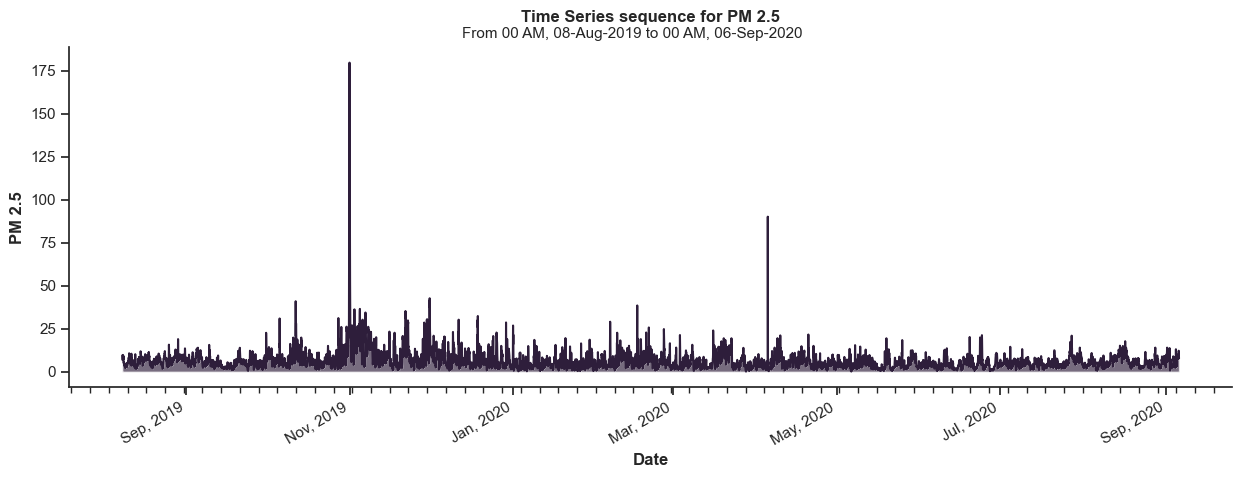

In [48]:
plot_sequence(exp_subset,
              value='PM 2.5')

In [49]:
exp_covariate = master_df.loc[master_df['Station'] != 'Vancouver_Clark_Drive_PM25', ['Station', 'PM 2.5']].pivot(columns='Station')
exp_covariate = exp_covariate.loc[
    datetime(2019, 8, 8):datetime(2020, 9, 6),
    ['PM 2.5']
]
exp_covariate.columns = exp_covariate.columns.droplevel()
exp_covariate

Station              North_Vancouver_Mahon_Park_PM25  \
DATE_PST                                               
2019-08-08 00:00:00                         8.239000   
2019-08-08 01:00:00                         6.951993   
2019-08-08 02:00:00                         6.105778   
2019-08-08 03:00:00                         5.782917   
2019-08-08 04:00:00                         5.916861   
...                                              ...   
2020-09-05 20:00:00                         7.654528   
2020-09-05 21:00:00                         8.907254   
2020-09-05 22:00:00                         8.824555   
2020-09-05 23:00:00                         9.195639   
2020-09-06 00:00:00                         8.527528   

Station              North_Vancouver_Second_Narrows_PM25  \
DATE_PST                                                   
2019-08-08 00:00:00                             8.142208   
2019-08-08 01:00:00                             6.881529   
2019-08-08 02:00:00                             6.196008   
2019-08-08 03:00:00                             6.208092   
2019-08-08 04:00:00                             6.548622   
...                                                  ...   
2020-09-05 20:00:00                            12.277000   
2020-09-05 21:00:00                            12.480280   
2020-09-05 22:00:00                            12.885890   
2020-09-05 23:00:00                            12.722110   
2020-09-06 00:00:00                            13.843940   

Station              Vancouver_International_Airport_#2_PM25  
DATE_PST                                                      
2019-08-08 00:00:00                                 6.760445  
2019-08-08 01:00:00                                 4.243104  
2019-08-08 02:00:00                                 3.064250  
2019-08-08 03:00:00                                 3.138083  
2019-08-08 04:00:00                                 3.423528  
...                                                      ...  
2020-09-05 20:00:00                                 6.189361  
2020-09-05 21:00:00                                 7.032000  
2020-09-05 22:00:00                                 5.531445  
2020-09-05 23:00:00                                 5.330194  
2020-09-06 00:00:00                                 5.485750  

[9481 rows x 3 columns]

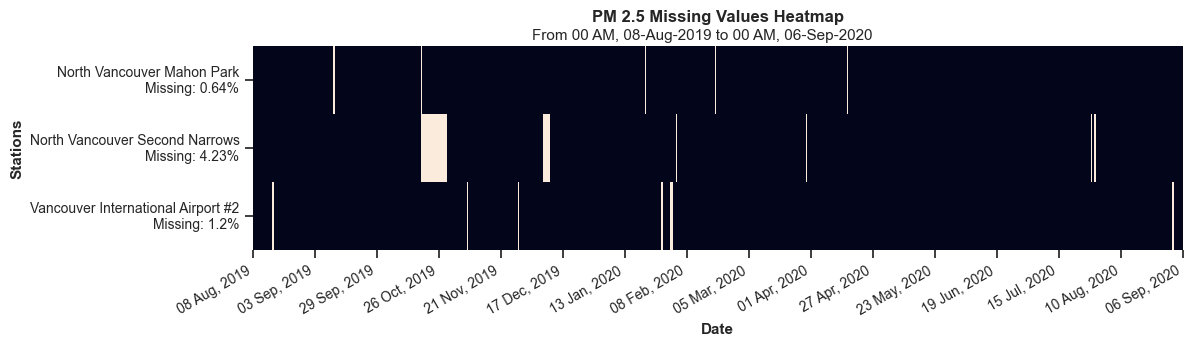

In [50]:
plot_missing(exp_covariate)

In [51]:
exp_covariate.fillna(method='ffill', inplace=True)

In [52]:
exp_subset_series = TimeSeries.from_dataframe(exp_subset)
exp_covariate_series = TimeSeries.from_dataframe(exp_covariate)

In [53]:
validation_cutoff = pd.Timestamp("2020-05-01")

train, val = exp_subset_series.split_after(validation_cutoff)

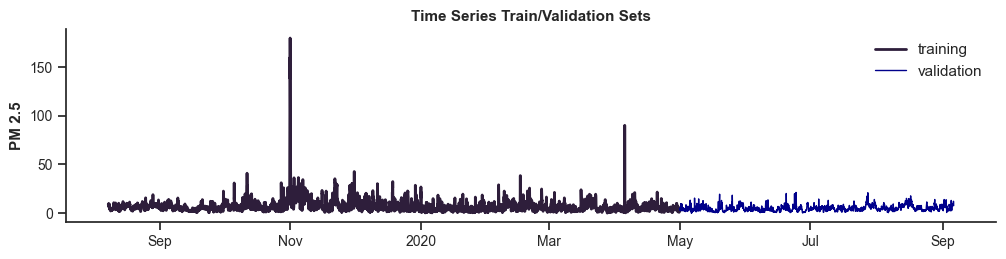

In [54]:
dart_plot(train, val)

In [55]:
max_lag = 48
step = 6

[-i for i in range(step, max_lag+step, step)]

[-6, -12, -18, -24, -30, -36, -42, -48]

#### Models Exploration

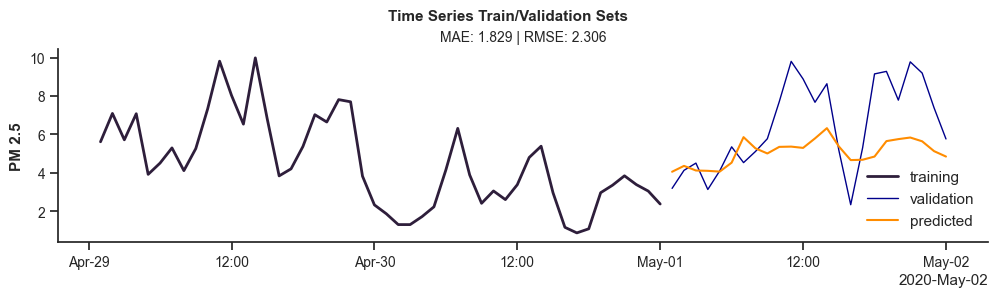

In [56]:
max_lag = 48
step = 6

lags = [-i for i in range(step, max_lag+step, step)]

model = LinearRegressionModel(
    lags=lags,
    output_chunk_length=1,
)
model.fit(train)
pred = model.predict(24)
dart_plot(train[-48:], val[:24], pred=pred)

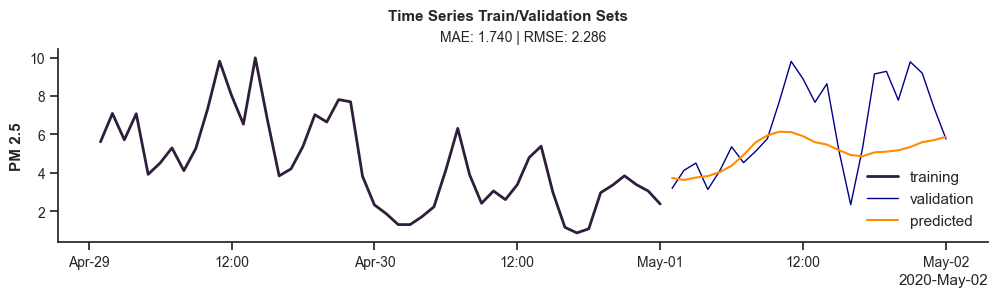

In [57]:
model = LinearRegressionModel(
    lags=lags,
    lags_past_covariates=lags,
    output_chunk_length=24,
)
model.fit(train, past_covariates=exp_covariate_series)
pred = model.predict(24)
dart_plot(train[-48:], val[:24], pred=pred)

In [58]:
from darts.models import XGBModel

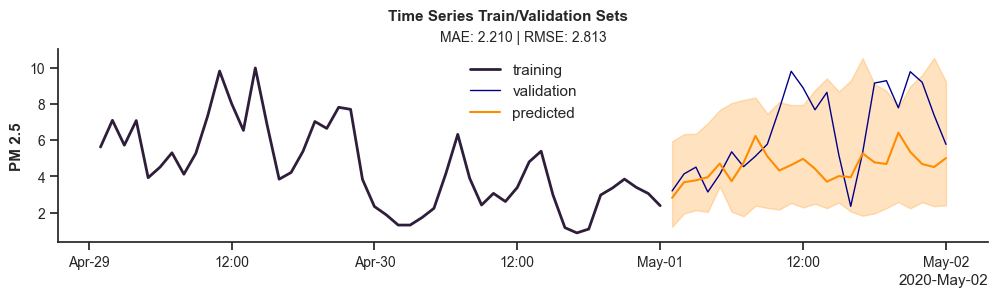

In [59]:
model = XGBModel(
    lags=lags,
    lags_past_covariates=lags,
    output_chunk_length=24,
    likelihood='quantile',
    quantiles=[0.05, 0.5, 0.95]
)
model.fit(train, past_covariates=exp_covariate_series)
pred = model.predict(n=24, num_samples=200)
dart_plot(train[-48:], val[:24], pred=pred)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


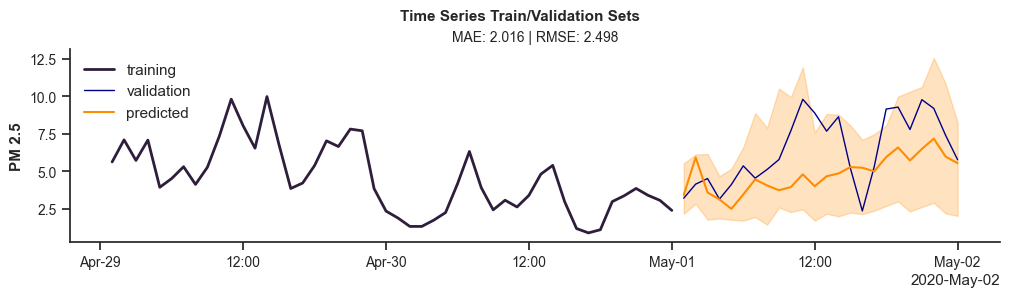

In [60]:
model = XGBModel(
    lags=lags,
    lags_past_covariates=lags,
    output_chunk_length=1,
    likelihood='quantile',
    quantiles=[0.05, 0.5, 0.95]
)
model.fit(train, past_covariates=exp_covariate_series)
pred = model.predict(n=24, num_samples=200)
dart_plot(train[-48:], val[:24], pred=pred)

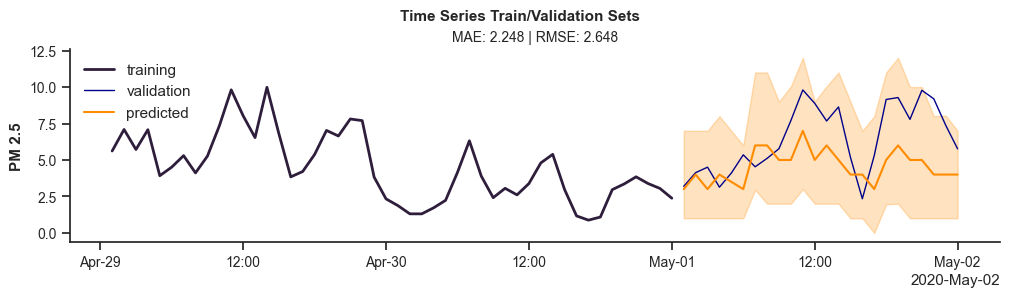

In [61]:
model = XGBModel(
    lags=lags,
    output_chunk_length=1,
    likelihood='poisson',
    random_state=123456
)
model.fit(train)
pred = model.predict(n=24, num_samples=200)
dart_plot(train[-48:], val[:24], pred=pred)

#### Model for missingness analysis

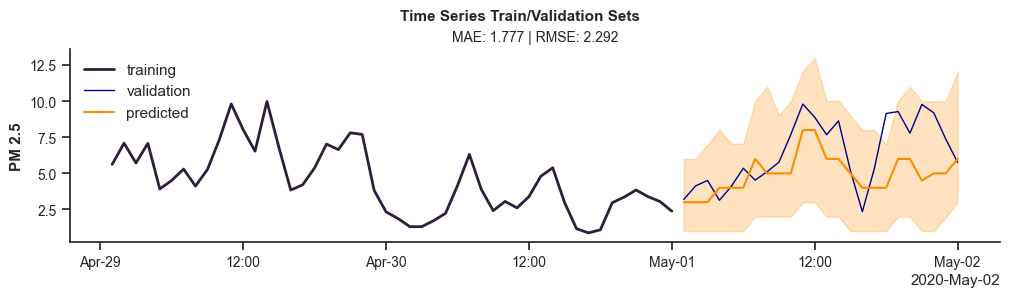

In [62]:
model = XGBModel(
    lags=lags,
    output_chunk_length=2,
    likelihood='poisson',
    random_state=123456
)
model.fit(train)
pred = model.predict(n=24, num_samples=200)
dart_plot(train[-48:], val[:24], pred=pred)

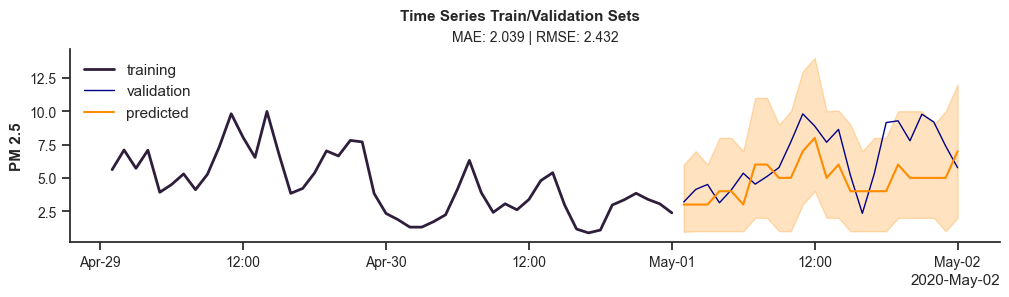

In [63]:
model = XGBModel(
    lags=lags,
    output_chunk_length=2,
    likelihood='poisson',
    random_state=42
)
model.fit(train)
pred = model.predict(n=24, num_samples=200)
dart_plot(train[-48:], val[:24], pred=pred)

In [64]:
from darts.explainability import ShapExplainer

The model is probabilistic, but num_samples=1 will be used for explainability.


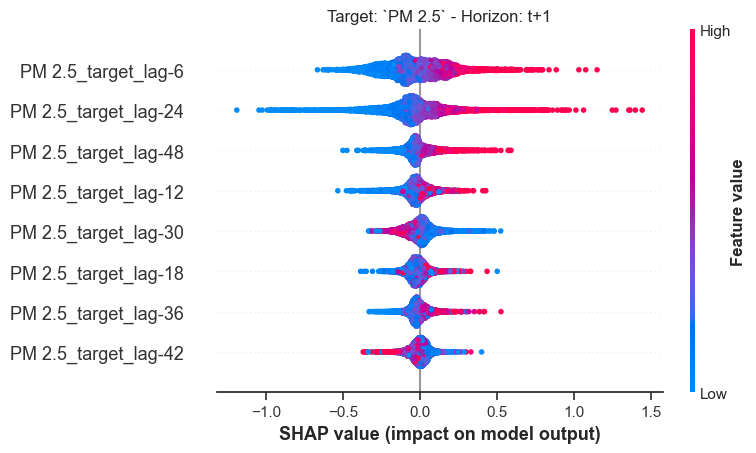

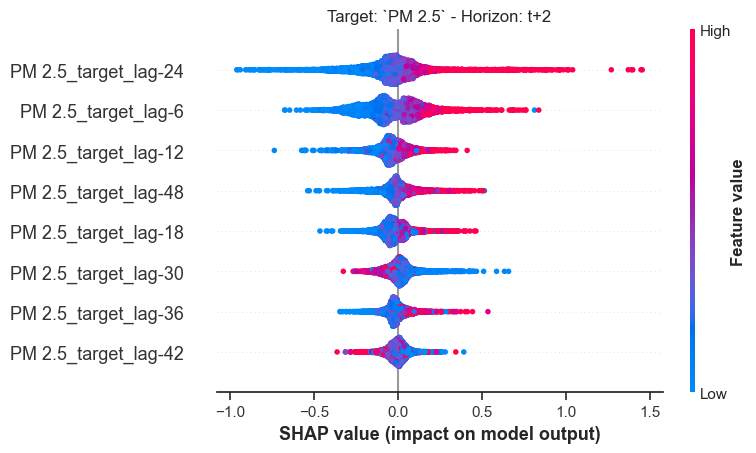

In [65]:
shap_explainer = ShapExplainer(model=model)
shap_values = shap_explainer.summary_plot()

In [66]:
from random import randrange
from datetime import timedelta

def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24)
    random_hour = randrange(int_delta)
    return start + timedelta(hours=random_hour)

2019-09-23 23:00:00


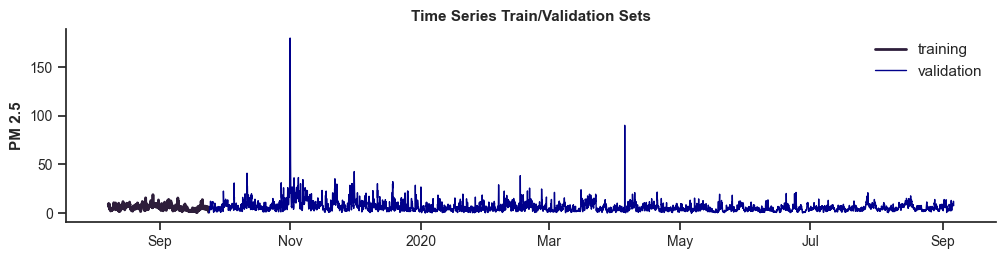

In [67]:
validation_cutoff = pd.Timestamp(random_date(datetime(2019, 8, 10), datetime(2020, 9, 5)))
print(validation_cutoff)

train, val = exp_subset_series.split_after(validation_cutoff)
dart_plot(train, val)

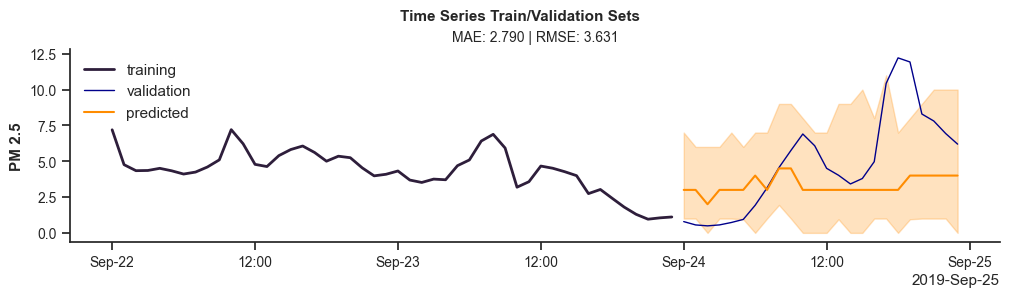

In [68]:
model = XGBModel(
    lags=lags,
    output_chunk_length=2,
    likelihood='poisson',
    random_state=42
)
model.fit(train)
pred = model.predict(n=24, num_samples=200)
dart_plot(train[-48:], val[:24], pred=pred)

2020-07-27 20:00:00


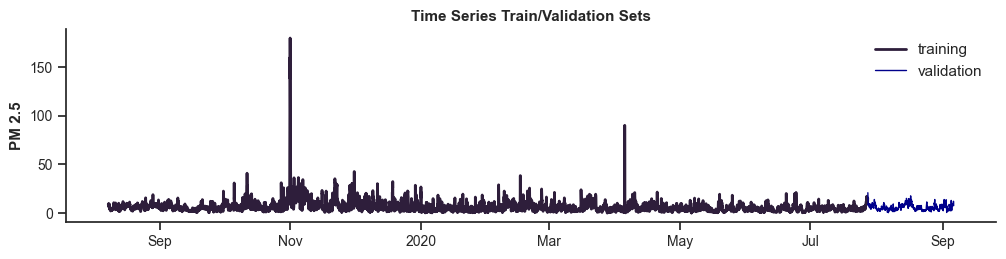

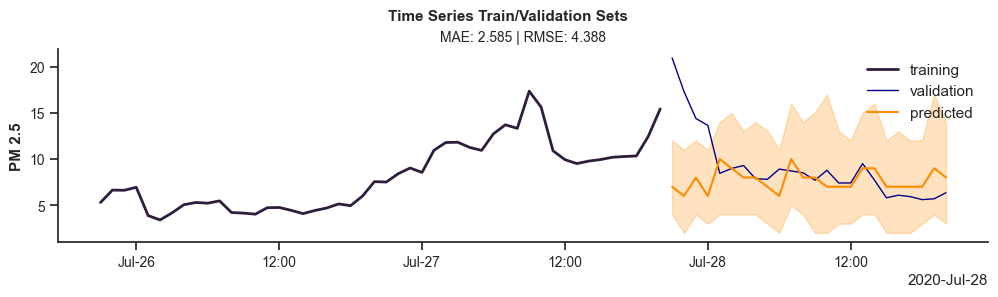

In [69]:
validation_cutoff = pd.Timestamp(random_date(datetime(2019, 8, 10), datetime(2020, 9, 5)))
print(validation_cutoff)

train, val = exp_subset_series.split_after(validation_cutoff)
dart_plot(train, val)

model = XGBModel(
    lags=lags,
    output_chunk_length=2,
    likelihood='poisson',
    random_state=42
)
model.fit(train)
pred = model.predict(n=24, num_samples=200)
dart_plot(train[-48:], val[:24], pred=pred)

2019-11-29 19:00:00


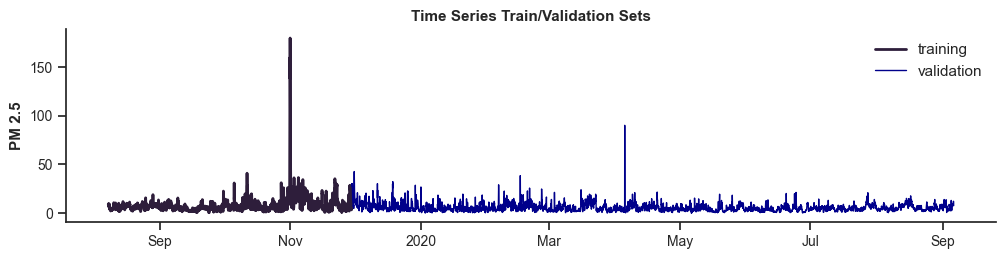

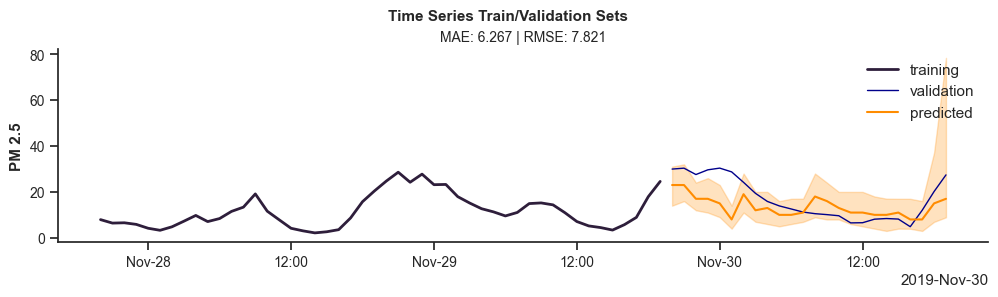

In [70]:
validation_cutoff = pd.Timestamp("2019-11-29 19:00:00")
# validation_cutoff = pd.Timestamp("2020-01-11 05:00:00")
# validation_cutoff = pd.Timestamp("2019-12-17 12:00:00")
# validation_cutoff = pd.Timestamp(random_date(datetime(2019, 8, 10), datetime(2020, 9, 5)))
print(validation_cutoff)

train, val = exp_subset_series.split_after(validation_cutoff)
dart_plot(train, val)

model = XGBModel(
    lags=lags,
    output_chunk_length=2,
    likelihood='poisson',
    random_state=42
)
model.fit(train)
pred = model.predict(n=24, num_samples=200)
dart_plot(train[-48:], val[:24], pred=pred)

In [71]:
'''
A probabilistic series will have shape (n_timesteps, n_target_variables, n_samples)
In our example we are outputing 200 samples of a 24h prediction window, of a single variable PM 2.5.
'''

pred.all_values().shape

(24, 1, 200)

In [72]:
'''
From our 200 samples we can observe the maximum and minimum point predictions.
'''
print(f'max: {pred.max(2).all_values().flatten()}')
print(f'min: {pred.min(2).all_values().flatten()}')

max: [ 34.  35.  29.  34.  31.  23.  30.  22.  26.  21.  20.  25.  35.  30.
  28.  27.  26.  21.  25.  20.  23.  21.  68. 118.]
min: [12. 11.  8.  6.  7.  3.  5.  3.  3.  0.  3.  4.  5.  5.  3.  4.  2.  0.
  0.  2.  0.  0.  0.  4.]


In [73]:
'''
As well as our upper (95%) and lower (5%) quantiles.
'''
print(f'0.95 quantile: {pred.quantile_timeseries(0.95).all_values().flatten()}')
print(f'0.05 quantile: {pred.quantile_timeseries(0.05).all_values().flatten()}')

0.95 quantile: [31.   32.   24.05 26.   23.   14.   28.   20.   20.   16.   17.   17.05
 28.   24.05 20.   20.   20.   18.   17.05 17.   17.   16.   37.1  78.4 ]
0.05 quantile: [14.   16.   12.   11.    9.    4.   11.    7.    6.    5.    6.    6.95
  8.95  8.    8.    6.    5.    4.    3.    4.    3.95  3.    6.95  8.95]


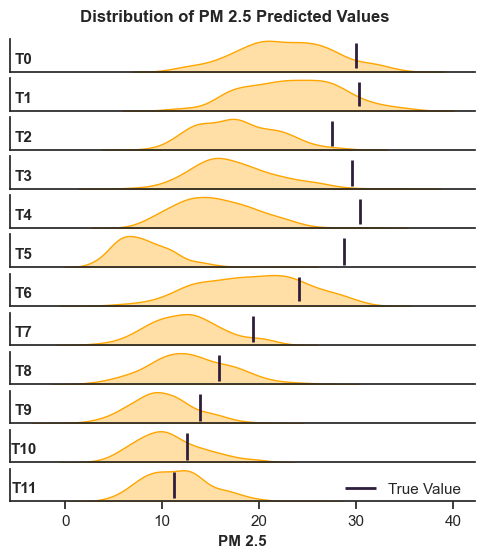

In [74]:
'''
It's also possible to visualize the distribution of each prediction step.
'''
def plot_pi_distribution(pred, val, steps=6):
    fig, axes = plt.subplots(steps, 1, figsize=(6, 6), sharex=True)
    fig.suptitle('Distribution of PM 2.5 Predicted Values', y=0.93, fontsize=12, fontweight='bold')

    # pred_values = {}
    for step in range(steps):
        # pred_values[step] = pred.all_values()[step, 0, :].tolist()
        sns.kdeplot(pred.all_values()[step, 0, :].tolist(), ax=axes[step], fill=True, color='orange', alpha=0.35)
        axes[step].vlines(val.values()[step][0], 0.01, 0.9*axes[step].get_ylim()[1], label='True Value', linewidth=2)
        axes[step].set_title(f'T{step}', x=0.03, y=0.02, fontsize=11, fontweight='bold')
        axes[step].set(yticks=[], ylabel="")
        axes[step].tick_params(bottom=False)
    # axes[0].legend()
    axes[-1].set_xlabel('PM 2.5', fontsize=11, fontweight='bold')
    axes[-1].tick_params(bottom=True)
    sns.despine()
    plt.legend()
    plt.show()

plot_pi_distribution(pred, val[:24], steps=12)

In [75]:
'''
Which we can then use to evaluate our prediction interval against our validation set,
and determine the coverage of our prediction interval.
'''

def evaluate_prediction_interval(pred: TimeSeries,
                                 val: TimeSeries,
                                 lower_quantile: float=0.05,
                                 upper_quantile: float=0.95) -> np.ndarray:
    '''
    Evaluates Prediction Interval coverage of the true values of the validation set.
    Returns an array of flags that indicates whether the prediction interval has
    the true value from the validation set.
    '''
    assert pred.is_probabilistic, "Prediction series must be probabilistic."
    assert pred.n_timesteps == val.n_timesteps, "Prediciton and Validation series must be of same length."

    # Lower and Upper prediction interval series
    lower_bound = pred.quantile_timeseries(lower_quantile).all_values().flatten()
    upper_bound = pred.quantile_timeseries(upper_quantile).all_values().flatten()

    # Validation set
    val_flatten = val.all_values().flatten()

    # Accuracy vector
    accuracy_vector = np.logical_and(
        val_flatten >= lower_bound,
        val_flatten <= upper_bound
    )

    return accuracy_vector

In [76]:
evaluate_prediction_interval(pred, val[:24])

array([ True,  True, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [77]:
coverage = sum(evaluate_prediction_interval(pred, val[:24]))/len(pred)
print(f'Prediction Interval coverage: {coverage*100:.2f} %')

Prediction Interval coverage: 83.33 %


2019-11-29 19:00:00


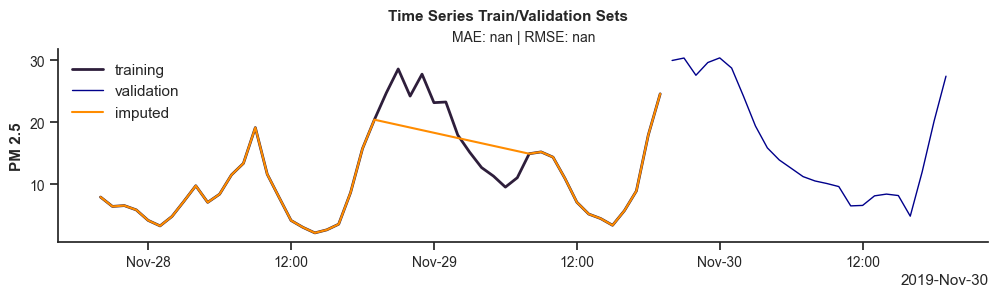

In [108]:
print(validation_cutoff)

train = exp_subset[:validation_cutoff]
val = exp_subset[validation_cutoff + timedelta(0, 3600):]

_, train_missing = create_missing(
        data=train,
        value="PM 2.5",
        missing_length=12,
        padding=12,
        missing_index="end",
)

# Linear interpolation
train_linear = train_missing.copy()
train_linear["PM 2.5"] = (
        train_missing["PM 2.5"].interpolate(method="linear").tolist()
)

# Converting to Dart TimeSeries
train = TimeSeries.from_dataframe(train)
train_missing = TimeSeries.from_dataframe(train_missing)
train_linear = TimeSeries.from_dataframe(train_linear)
val = TimeSeries.from_dataframe(val)


dart_plot(train[-48:], val[:24], pred=train_linear[-48:], pred_label="imputed")

2019-11-29 19:00:00


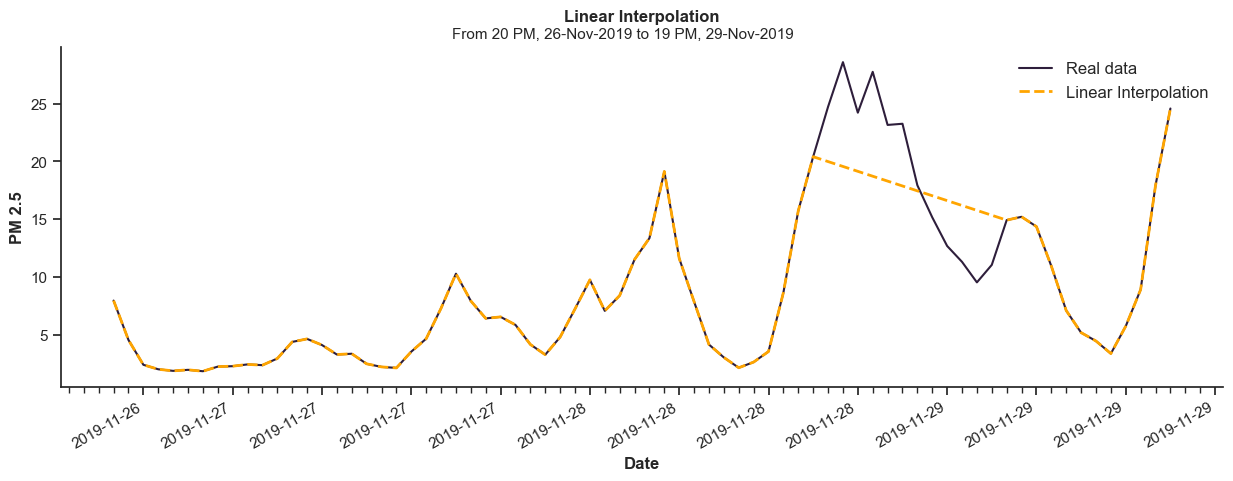

In [115]:
print(validation_cutoff)

train = exp_subset[:validation_cutoff]
val = exp_subset[validation_cutoff + timedelta(0, 3600):]

_, train_missing = create_missing(
        data=train,
        value="PM 2.5",
        missing_length=12,
        padding=12,
        missing_index="end",
)

# Linear interpolation
train_linear = train_missing.copy()
train_linear["PM 2.5"] = (
        train_missing["PM 2.5"].interpolate(method="linear").tolist()
)

plot_compare(
    train_linear[-72:],
    train[-72:],
    value="PM 2.5",
    value_missing="PM 2.5",
    plot_title="Linear Interpolation",
    data_label="Linear Interpolation",
    fill=False
)

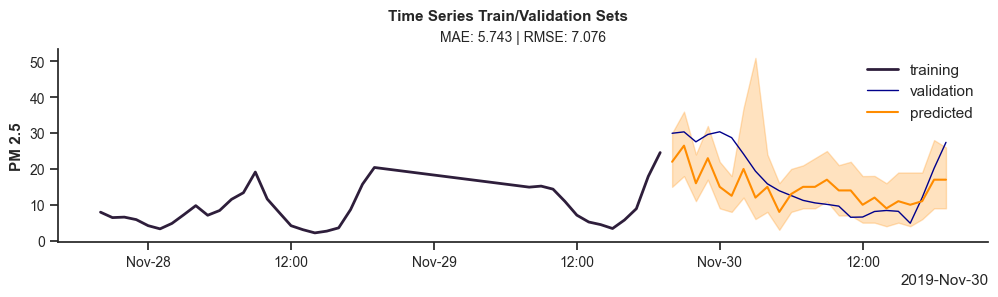

In [116]:
# Converting to Dart TimeSeries
train = TimeSeries.from_dataframe(train)
train_missing = TimeSeries.from_dataframe(train_missing)
train_linear = TimeSeries.from_dataframe(train_linear)
val = TimeSeries.from_dataframe(val)

model = XGBModel(
    lags=lags,
    output_chunk_length=2,
    likelihood='poisson',
    random_state=42
)
model.fit(train_linear)
pred = model.predict(n=24, num_samples=200)
dart_plot(train_linear[-48:], val[:24], pred=pred)

In [117]:
coverage = sum(evaluate_prediction_interval(pred, val[:24]))/len(pred)
print(f'Prediction Interval coverage: {coverage*100:.2f} %')

Prediction Interval coverage: 75.00 %


2019-11-29 19:00:00


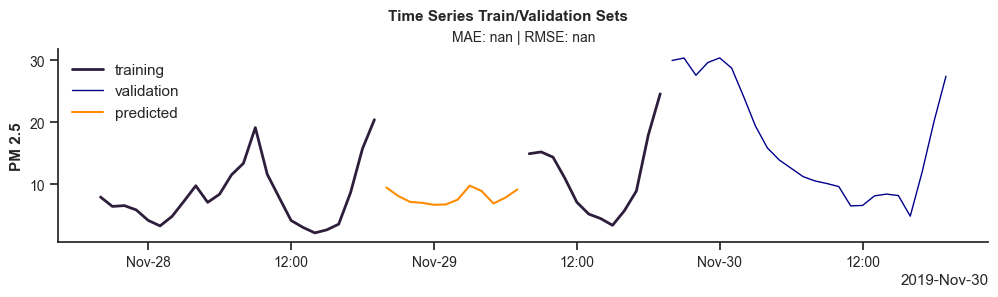

In [118]:
# FFT
from darts.models import FFT

# validation_cutoff = pd.Timestamp("2019-11-29 19:00:00")
print(validation_cutoff)

train = exp_subset[:validation_cutoff]
val = exp_subset[validation_cutoff + timedelta(0, 3600):]

_, train_missing = create_missing(
        data=train,
        value="PM 2.5",
        missing_length=12,
        padding=12,
        missing_index="end",
)

# Converting to Dart TimeSeries
train = TimeSeries.from_dataframe(train)

# FFT imputation
fft_model = FFT(nr_freqs_to_keep=None)
fft_model.fit(train[:(-24)]) # -(missing_length + padding)
fft_pred = fft_model.predict((12))

train_missing = TimeSeries.from_dataframe(train_missing)
val = TimeSeries.from_dataframe(val)

dart_plot(train_missing[-48:], val[:24], pred=fft_pred)

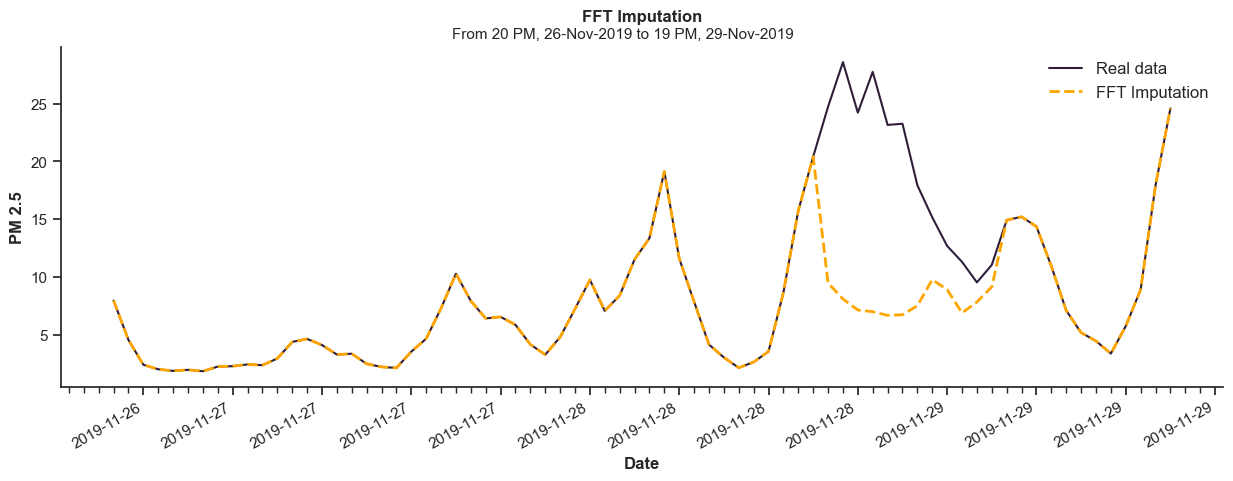

In [121]:
train_fft_imputed_df = train_missing.pd_dataframe().copy()
fft_pred_df = fft_pred.pd_dataframe().copy()
train_fft_imputed_df.loc[train_fft_imputed_df["PM 2.5"].isna()] = fft_pred_df[["PM 2.5"]]

plot_compare(
    train_fft_imputed_df[-72:],
    train[-72:].pd_dataframe(),
    value="PM 2.5",
    value_missing="PM 2.5",
    plot_title="FFT Imputation",
    data_label="FFT Imputation",
    fill=False
)

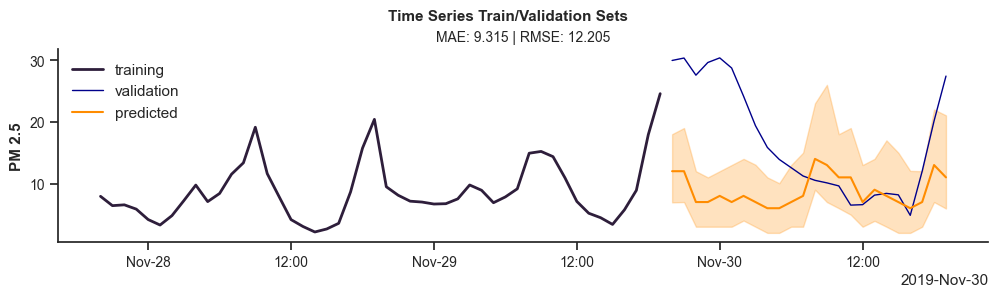

In [84]:
train_fft_imputed = TimeSeries.from_dataframe(train_fft_imputed_df)

model = XGBModel(
    lags=lags,
    output_chunk_length=2,
    likelihood='poisson',
    random_state=42
)
model.fit(train_fft_imputed)
pred = model.predict(n=24, num_samples=200)
dart_plot(train_fft_imputed[-48:], val[:24], pred=pred)

In [85]:
coverage = sum(evaluate_prediction_interval(pred, val[:24]))/len(pred)
print(f'Prediction Interval coverage: {coverage*100:.2f} %')

Prediction Interval coverage: 54.17 %


The model is probabilistic, but num_samples=1 will be used for explainability.


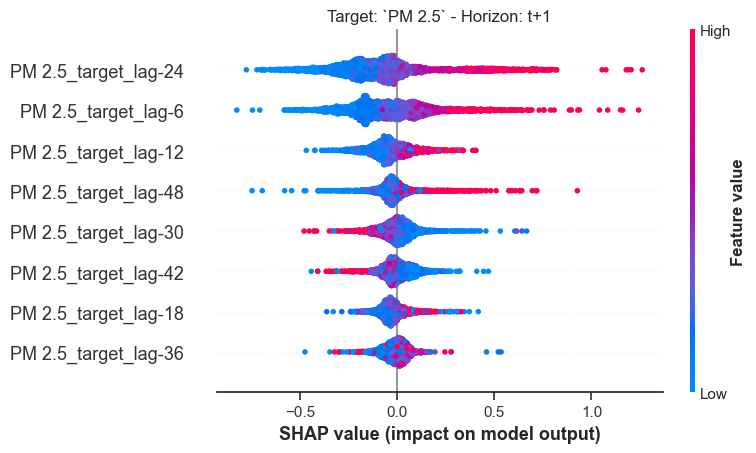

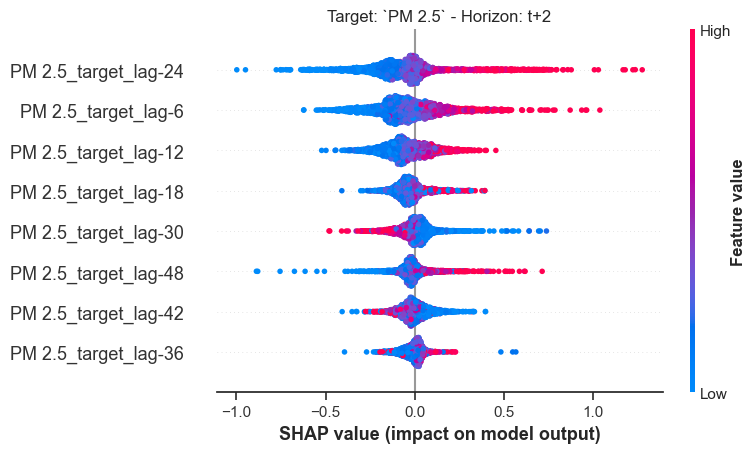

In [86]:
shap_explainer = ShapExplainer(model=model)
shap_values = shap_explainer.summary_plot()

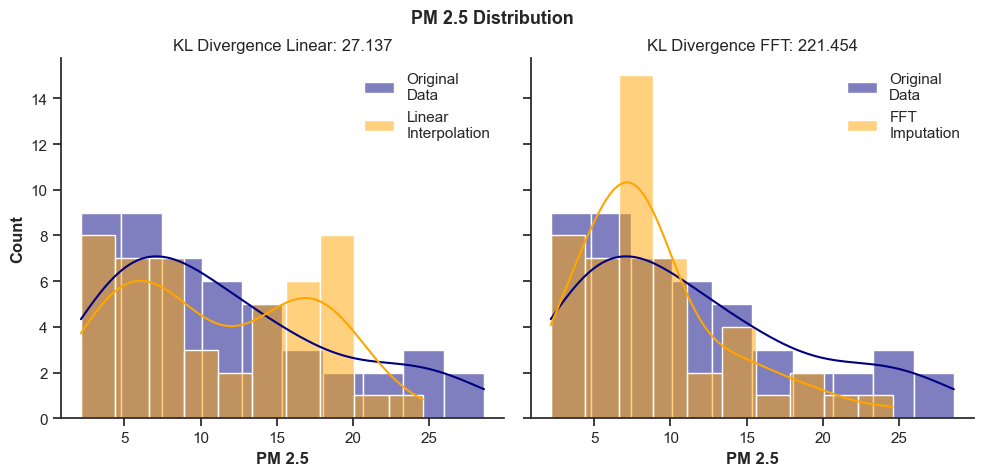

In [107]:
# KL Divergence
from scipy.special import rel_entr

KL_Div_linear = sum(rel_entr(train[-48:].values(), train_linear[-48:].values()))
KL_Div_fft = sum(rel_entr(train[-48:].values(), train_fft_imputed[-48:].values()))

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

sns.histplot(train[-48:].pd_dataframe(), x="PM 2.5", label="Original\nData", kde=True, color="navy", bins=10, ax=axes[0])
sns.histplot(train_linear[-48:].pd_dataframe(), x="PM 2.5", label="Linear\nInterpolation", kde=True, color="orange", bins=10,  ax=axes[0])
sns.histplot(train[-48:].pd_dataframe(), x="PM 2.5", label="Original\nData", kde=True, color="navy", bins=10, ax=axes[1])
sns.histplot(train_fft_imputed[-48:].pd_dataframe(), x="PM 2.5", label="FFT\nImputation", kde=True, color="orange", bins=10,  ax=axes[1])
plt.suptitle(f"PM 2.5 Distribution", fontsize=13, fontweight="bold", y=0.95)
axes[0].set(title=f"KL Divergence Linear: {KL_Div_linear[0]:.3f}")
axes[0].legend()
axes[1].set(title=f"KL Divergence FFT: {KL_Div_fft[0]:.3f}")
axes[1].legend()
plt.xlabel("PM 2.5")
plt.tight_layout()
sns.despine()
plt.show()

### Iterating Through Missing Lengths and Paddins

In [297]:
%%time
forecast_horizon = 24
max_lag = 48
step = 6
lags = [-i for i in range(step, max_lag+step, step)]

def build_xgbmodel(lags):
    model = XGBModel(
        lags=lags,
        output_chunk_length=2,
        likelihood='poisson',
        random_state=42
    )
    return model

imputation_metrics = {}
imputation_metrics["Imputation_Method"] = []
imputation_metrics["Imputation_MAE"] = []
imputation_metrics["Imputation_RMSE"] = []
imputation_metrics["Imputation_KL_Divergence"] = []
imputation_metrics["Prediction_MAE"] = []
imputation_metrics["Prediction_RMSE"] = []
imputation_metrics["Prediction_Interval_Coverage"] = []
imputation_metrics["Validation_Cutoff"] = []
imputation_metrics["Padding"] = []
imputation_metrics["Missing_Length"] = []

# Paddings to shift missing intervals from 2 to 48 hours before the training series end
paddings = [i for i in range(2, 48)]
missing_lengths = [3, 6, 12, 24]
iterations = range(1, 6)

# iterations = [
#     "2019-11-10 01:00:00",
#     "2020-02-09 13:00:00",
#     "2020-04-24 14:00:00",
#     "2020-05-04 22:00:00",
#     "2020-07-19 11:00:00",
# ]

for iteration in iterations:
    print(f"Starting iteration {iteration}...")
    validation_cutoff = pd.Timestamp(random_date(datetime(2019, 9, 10), datetime(2020, 9, 5)))
    # validation_cutoff = pd.Timestamp(iteration)
    train_series, val_series = exp_subset_series.split_after(validation_cutoff)
    train_df = exp_subset[:validation_cutoff]
    val_df = exp_subset[validation_cutoff + timedelta(0, 3600):]
    
    ### Fitting baseline XGBoost Model to complete training data
    model = build_xgbmodel(lags)
    model.fit(train_series)
    pred_series = model.predict(n=forecast_horizon, num_samples=200)
    # Baseline metrics from complete training data
    imputation_metrics["Imputation_Method"].append("Original Data")
    imputation_metrics["Imputation_MAE"].append(0)
    imputation_metrics["Imputation_RMSE"].append(0)
    imputation_metrics["Imputation_KL_Divergence"].append(0)
    imputation_metrics["Prediction_MAE"].append(mae(pred_series, val_series))
    imputation_metrics["Prediction_RMSE"].append(rmse(pred_series, val_series))
    imputation_metrics["Prediction_Interval_Coverage"].append(
        sum(evaluate_prediction_interval(pred_series, val_series[:forecast_horizon]))/len(pred_series)
    )
    imputation_metrics["Validation_Cutoff"].append(validation_cutoff)
    imputation_metrics["Padding"].append(0)
    imputation_metrics["Missing_Length"].append(0)

    for padding in (pbar := tqdm(paddings)):
        pbar.set_description(f"Processing padding {padding}")
        for missing_length in missing_lengths:
            _, train_missing_df = create_missing(
                data=train_df,
                value="PM 2.5",
                padding=padding,
                missing_length=missing_length,
                missing_index="end"
            )

            ### Linear Interpolation
            train_linear_df = train_missing_df.copy()
            train_linear_df["PM 2.5"] = train_missing_df["PM 2.5"].interpolate(method="linear").tolist()
            train_linear_series = TimeSeries.from_dataframe(train_linear_df)
            # Fit XGBoost
            model = build_xgbmodel(lags)
            model.fit(train_linear_series)
            pred_linear_series = model.predict(n=forecast_horizon, num_samples=200)
            # Linear Interpolation Metrics
            imputation_metrics["Imputation_Method"].append("Linear Interpolation")
            imputation_metrics["Imputation_MAE"].append(mae(train_linear_series[-48:], train_series[-48:]))
            imputation_metrics["Imputation_RMSE"].append(rmse(train_linear_series[-48:], train_series[-48:]))
            imputation_metrics["Imputation_KL_Divergence"].append(
                sum(rel_entr(train_series[-48:].values(), train_linear_series[-48:].values()))[0]
            )
            imputation_metrics["Prediction_MAE"].append(mae(pred_linear_series, val_series))
            imputation_metrics["Prediction_RMSE"].append(rmse(pred_linear_series, val_series))
            imputation_metrics["Prediction_Interval_Coverage"].append(
                sum(evaluate_prediction_interval(pred_linear_series, val_series[:forecast_horizon]))/len(pred_linear_series)
            )
            imputation_metrics["Validation_Cutoff"].append(validation_cutoff)
            imputation_metrics["Padding"].append(padding)
            imputation_metrics["Missing_Length"].append(missing_length)

            ### FFT Imputation
            fft_model = FFT(nr_freqs_to_keep=None)
            fft_model.fit(train_series[:-(missing_length+padding)])
            fft_pred_series = fft_model.predict(missing_length)
            fft_pred_df = fft_pred_series.pd_dataframe().copy()
            train_fft_df = train_missing_df.copy()
            train_fft_df.loc[train_fft_df["PM 2.5"].isna()] = fft_pred_df[["PM 2.5"]]
            train_fft_series = TimeSeries.from_dataframe(train_fft_df)
            # Fit XGBoost
            model = build_xgbmodel(lags)
            model.fit(train_fft_series)
            pred_fft_series = model.predict(n=forecast_horizon, num_samples=200)
            # FFT Imputation Metrics
            imputation_metrics["Imputation_Method"].append("FFT Imputation")
            imputation_metrics["Imputation_MAE"].append(mae(train_fft_series[-48:], train_series[-48:]))
            imputation_metrics["Imputation_RMSE"].append(rmse(train_fft_series[-48:], train_series[-48:]))
            imputation_metrics["Imputation_KL_Divergence"].append(
                sum(rel_entr(train_series[-48:].values(), train_fft_series[-48:].values()))[0]
            )
            imputation_metrics["Prediction_MAE"].append(mae(pred_fft_series, val_series))
            imputation_metrics["Prediction_RMSE"].append(rmse(pred_fft_series, val_series))
            imputation_metrics["Prediction_Interval_Coverage"].append(
                sum(evaluate_prediction_interval(pred_fft_series, val_series[:forecast_horizon]))/len(pred_fft_series)
            )
            imputation_metrics["Validation_Cutoff"].append(validation_cutoff)
            imputation_metrics["Padding"].append(padding)
            imputation_metrics["Missing_Length"].append(missing_length)

Starting iteration 2019-11-10 01:00:00...


Processing padding 47: 100%|██████████| 46/46 [01:24<00:00,  1.84s/it]


Starting iteration 2020-02-09 13:00:00...


Processing padding 47: 100%|██████████| 46/46 [01:36<00:00,  2.10s/it]


Starting iteration 2020-04-24 14:00:00...


Processing padding 47: 100%|██████████| 46/46 [01:51<00:00,  2.43s/it]


Starting iteration 2020-05-04 22:00:00...


Processing padding 47: 100%|██████████| 46/46 [02:09<00:00,  2.82s/it]


Starting iteration 2020-07-19 11:00:00...


Processing padding 47: 100%|██████████| 46/46 [02:29<00:00,  3.25s/it]

CPU times: user 42min 9s, sys: 19min 16s, total: 1h 1min 25s
Wall time: 9min 33s


In [298]:
'''
    - For the period with the 
    (
        obs1: Don't compare prediction metrics between an imputation method and the original data. Only compare it between imputation methods.
        obs2: For the period that was harder for the model to predict, the prediction metrics oscilated around the original data's prediction metric.
            That happened simply because the model did not perform well for that period.
    )
'''
imputation_metrics_df = pd.DataFrame(imputation_metrics)
imputation_metrics_df["Abs_Imputation_KL_Divergence"] = abs(imputation_metrics_df["Imputation_KL_Divergence"])
imputation_metrics_df.groupby(["Validation_Cutoff", "Imputation_Method"]).agg("mean")[
    ["Imputation_MAE", "Imputation_RMSE", "Abs_Imputation_KL_Divergence", "Prediction_MAE", "Prediction_RMSE", "Prediction_Interval_Coverage"]
]

Imputation_MAE  Imputation_RMSE  \
Validation_Cutoff   Imputation_Method                                       
2019-11-10 01:00:00 FFT Imputation              1.851392         4.113910   
                    Linear Interpolation        0.719518         1.590618   
                    Original Data               0.000000         0.000000   
2020-02-09 13:00:00 FFT Imputation              0.774879         1.932533   
                    Linear Interpolation        0.618422         1.522135   
                    Original Data               0.000000         0.000000   
2020-04-24 14:00:00 FFT Imputation              0.705729         1.742405   
                    Linear Interpolation        0.400698         0.896722   
                    Original Data               0.000000         0.000000   
2020-05-04 22:00:00 FFT Imputation              0.627922         1.527195   
                    Linear Interpolation        0.273124         0.619559   
                    Original Data               0.000000         0.000000   
2020-07-19 11:00:00 FFT Imputation              0.748932         1.786997   
                    Linear Interpolation        0.148825         0.360663   
                    Original Data               0.000000         0.000000   

                                          Abs_Imputation_KL_Divergence  \
Validation_Cutoff   Imputation_Method                                    
2019-11-10 01:00:00 FFT Imputation                          142.842407   
                    Linear Interpolation                     27.154847   
                    Original Data                             0.000000   
2020-02-09 13:00:00 FFT Imputation                           19.044120   
                    Linear Interpolation                     25.720833   
                    Original Data                             0.000000   
2020-04-24 14:00:00 FFT Imputation                           14.152967   
                    Linear Interpolation                     15.087782   
                    Original Data                             0.000000   
2020-05-04 22:00:00 FFT Imputation                           16.220867   
                    Linear Interpolation                     10.235347   
                    Original Data                             0.000000   
2020-07-19 11:00:00 FFT Imputation                           19.336826   
                    Linear Interpolation                      5.198491   
                    Original Data                             0.000000   

                                          Prediction_MAE  Prediction_RMSE  \
Validation_Cutoff   Imputation_Method                                       
2019-11-10 01:00:00 FFT Imputation              4.847824         5.572265   
                    Linear Interpolation        5.152846         5.773211   
                    Original Data               5.026622         5.449263   
2020-02-09 13:00:00 FFT Imputation              4.782277         5.635220   
                    Linear Interpolation        4.930701         5.745717   
                    Original Data               4.841880         5.684042   
2020-04-24 14:00:00 FFT Imputation              2.066969         2.458137   
                    Linear Interpolation        2.020145         2.408365   
                    Original Data               1.841921         2.226681   
2020-05-04 22:00:00 FFT Imputation              1.959467         2.680520   
                    Linear Interpolation        1.943535         2.684873   
                    Original Data               1.819798         2.542132   
2020-07-19 11:00:00 FFT Imputation              1.507711         1.748495   
                    Linear Interpolation        1.383456         1.604505   
                    Original Data               1.209629         1.450214   

                                          Prediction_Interval_Coverage  
Validation_Cutoff   Imputation_Method                                   
2019-11-10 01:00:

In [307]:
imputation_metrics_df.groupby(["Imputation_Method", "Missing_Length"]).agg("mean")[
    ["Imputation_MAE", "Imputation_RMSE", "Abs_Imputation_KL_Divergence", "Prediction_MAE", "Prediction_RMSE", "Prediction_Interval_Coverage"]
]

Imputation_MAE  Imputation_RMSE  \
Imputation_Method    Missing_Length                                    
FFT Imputation       3                     0.317518         1.336150   
                     6                     0.571776         1.772791   
                     12                    1.151931         2.653595   
                     24                    1.725858         3.119896   
Linear Interpolation 3                     0.070482         0.320874   
                     6                     0.186096         0.625031   
                     12                    0.496254         1.227249   
                     24                    0.975639         1.818604   
Original Data        0                     0.000000         0.000000   

                                     Abs_Imputation_KL_Divergence  \
Imputation_Method    Missing_Length                                 
FFT Imputation       3                                  12.713624   
                     6                                  24.667589   
                     12                                 45.675537   
                     24                                 86.220999   
Linear Interpolation 3                                   2.894097   
                     6                                   7.504065   
                     12                                 19.973985   
                     24                                 36.345692   
Original Data        0                                   0.000000   

                                     Prediction_MAE  Prediction_RMSE  \
Imputation_Method    Missing_Length                                    
FFT Imputation       3                     3.109072         3.661028   
                     6                     3.064837         3.637107   
                     12                    3.069697         3.669728   
                     24                    2.887792         3.507847   
Linear Interpolation 3                     3.106883         3.647992   
                     6                     3.093548         3.629802   
                     12                    3.117200         3.685029   
                     24                    3.026915         3.610513   
Original Data        0                     2.947970         3.470466   

                                     Prediction_Interval_Coverage  
Imputation_Method    Missing_Length                                
FFT Imputation       3                                   0.792391  
                     6                                   0.798007  
                     12                                  0.796014  
                     24                                  0.814855  
Linear Interpolation 3                                   0.793116  
                     6                                   0.792754  
                     12                                  0.792029  
                     24                                  0.797101  
Original Data        0                                   0.800000

2019-11-10 01:00:00


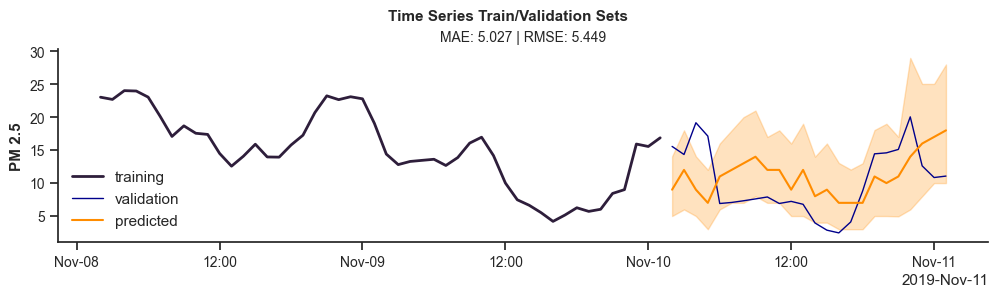

2020-02-09 13:00:00


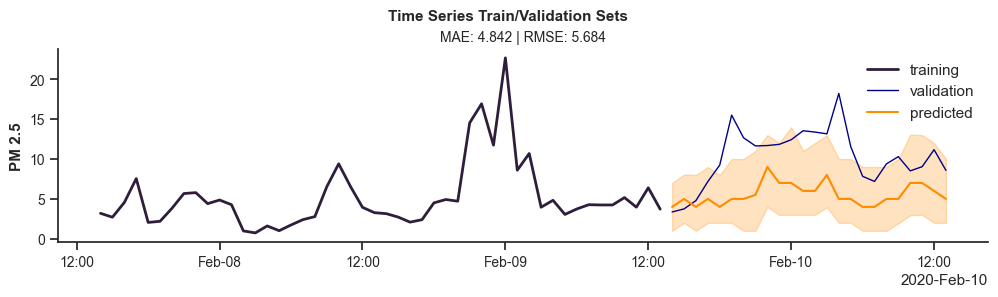

2020-04-24 14:00:00


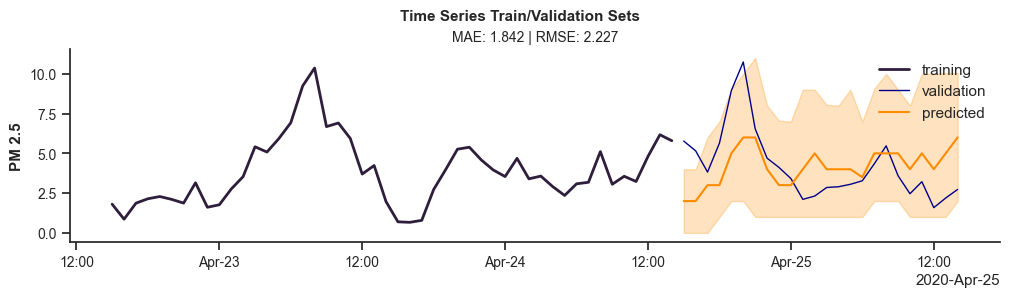

2020-05-04 22:00:00


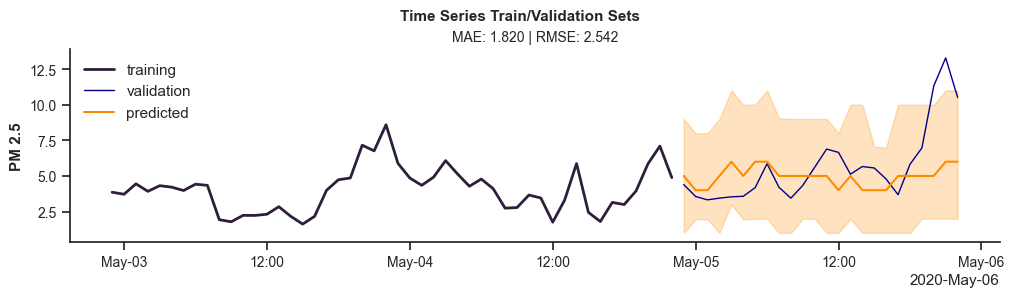

2020-07-19 11:00:00


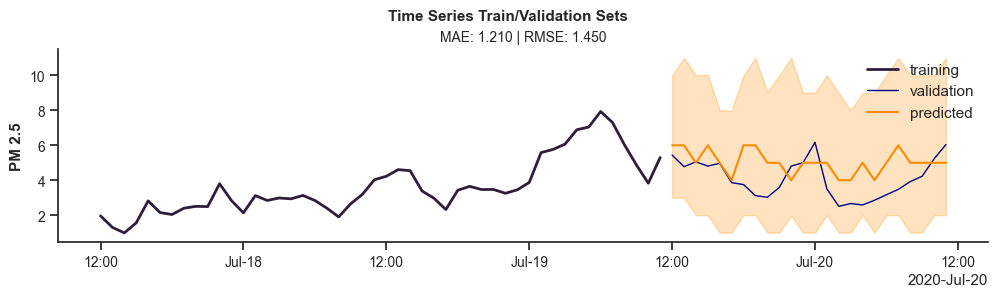

In [304]:
for validation_cutoff in imputation_metrics_df["Validation_Cutoff"].unique():
    print(validation_cutoff)

    train, val = exp_subset_series.split_after(validation_cutoff)
    # dart_plot(train, val)

    model = XGBModel(
        lags=lags,
        output_chunk_length=2,
        likelihood='poisson',
        random_state=42
    )
    model.fit(train)
    pred = model.predict(n=24, num_samples=200)
    dart_plot(train[-48:], val[:24], pred=pred)

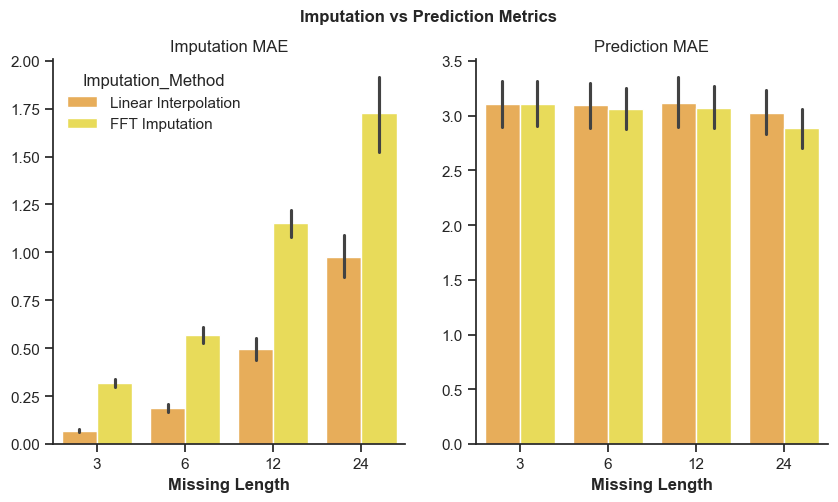

In [366]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
b1 = sns.barplot(
    imputation_metrics_df.loc[imputation_metrics_df["Imputation_Method"].isin([
            "Linear Interpolation", "FFT Imputation"
        ])],
    x="Missing_Length",
    y="Imputation_MAE",
    hue="Imputation_Method",
    palette={
        "Linear Interpolation": "#FFB142",
        "FFT Imputation": "#FFEF43"
    },
    ax=axs[0]
)
b1.set(ylabel=None)
b1.set(xlabel="Missing Length")
b1.set(title="Imputation MAE")
b2 = sns.barplot(
    imputation_metrics_df.loc[imputation_metrics_df["Imputation_Method"].isin([
            "Linear Interpolation", "FFT Imputation"
        ])],
    x="Missing_Length",
    y="Prediction_MAE",
    hue="Imputation_Method",
    palette={
        "Original Data": "#3E2D5F",
        "Linear Interpolation": "#FFB142",
        "FFT Imputation": "#FFEF43"
    },
    legend=False,
    ax=axs[1]
)
b2.set(ylabel=None)
b2.set(xlabel="Missing Length")
b2.set(title="Prediction MAE")
plt.suptitle("Imputation vs Prediction Metrics", fontsize=12, fontweight="bold")
sns.despine()
plt.show()

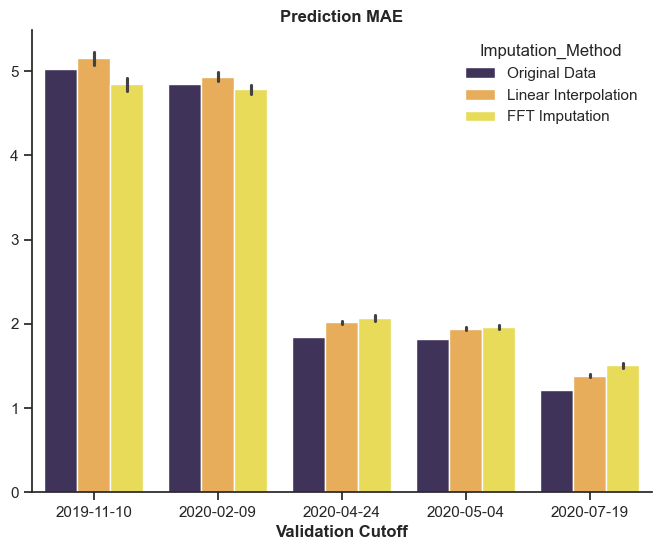

In [340]:
imputation_metrics_df["Validation_Cutoff_Short"] = imputation_metrics_df["Validation_Cutoff"].dt.strftime("%Y-%m-%d")

plt.figure(figsize=(8, 6))
b = sns.barplot(
    imputation_metrics_df,
    x="Validation_Cutoff_Short",
    y="Prediction_MAE",
    hue="Imputation_Method",
    palette={
        "Original Data": "#3E2D5F",
        "Linear Interpolation": "#FFB142",
        "FFT Imputation": "#FFEF43"
    }
)

b.set(ylabel=None)
b.set(xlabel="Validation Cutoff")
plt.title("Prediction MAE", fontsize=12, fontweight="bold")
sns.despine()
plt.show()